In [1]:
# Tenta fazer o ciclo de calculo e ter graficos decentes
# Desenha cada molécula com os dados atribuidos
# Cria um dataframe das substâncias
# Plota gráficos minimos.
# Criado por Ed Trawtmam, v0.5, em 29/10/2021
# Criado por Ed Trawtmam, v0.6, em 24/11/2021
############################################################################################################################

# Calcula o HSP segundo Mathieu 2018, por otimização (vários algoritmos) e compara com a bibliografia (Abbott);
# Adiciona Flory, solução ideal e Gibbs de mistura de acordo com Abbott e Louwerse

#!/usr/bin/python
# -*- coding: utf-8 -*-
# script file to compute HSP components of pure compounds
# note that the rdkit library is required
# units: MPa**1/2 and cc/mol para HSP

In [2]:
#@title
# Instala o RDkit
! pip install rdkit-pypi
# Para plotar gráficos...
!pip install plotly==4.12.0
!pip install jupyter-dash
!pip install -U pandas-profiling#[notebook]

     |████████████████████████████████| 20.6 MB 1.3 MB/s 
     |████████████████████████████████| 13.1 MB 5.0 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 7.3 MB 6.9 MB/s 
     |████████████████████████████████| 25.3 MB 60.5 MB/s 
     |████████████████████████████████| 357 kB 37.8 MB/s 
  Created wheel for dash-core-components: filename=dash_core_components-2.0.0-py3-none-any.whl size=3821 sha256=e85b9ad04ad371c343b1e76ba3d57c0a7d474dfe77ee1dceb898a22009963e57
  Stored in directory: /root/.cache/pip/wheels/00/f9/c7/1a6437d794ed753ea9bc9079e761d4fc803a1f1f5d3697b9ec
  Created wheel for dash-html-components: filename=dash_html_components-2.0.0-py3-none-any.whl size=4089 sha256=fbd941631ed02d290802186d25d5f08da31705c66e3de07bcb672bedb7c0d8ea
  Stored in directory: /root/.cache/pip/wheels/ec/6b/81/05aceabd8b27f724e2c96784016287cc1bfbc349e

In [3]:
!pip install xlsxwriter

     |████████████████████████████████| 149 kB 5.3 MB/s 


In [4]:
#@title
# Pra planilha automática
#!pip install dtale

# Pra salvar pdf's
!pip install weasyprint
from weasyprint import HTML


     |████████████████████████████████| 242 kB 5.5 MB/s 
     |████████████████████████████████| 2.0 MB 22.3 MB/s 
     |████████████████████████████████| 113 kB 48.0 MB/s 


Instaladas todas as dependências, hora de carregar as bibliotecas necessárias nos vários módulos do programa. Talvez fosse melhor modularizar mais...

In [5]:
#@title
import sys, os, fileinput
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from math import sqrt
from math import log
import math
from collections import Counter, OrderedDict, defaultdict
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem import Descriptors
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
pd.options.plotting.backend = 'plotly'
import pandas_profiling
from rdkit.Chem import PandasTools
import plotly.express as px
#import plotly as px
import plotly.graph_objects as go # Talvez inutil
from plotly.subplots import make_subplots
import numpy as np
from numpy import exp
from numpy import sqrt
from numpy import e
from scipy.optimize import minimize
import scipy.stats as stats
#from scipy.stats import gmean

Cria as bibliotecas de dados publicadas por Mathieu para a estimação dos parâmetros de Hansen à partir da soma das contribuições por grupos funcionais. A mesma técnica também é utilizada para determinar o volume molar e o índice de refração da molécula. As funções de cálculo, modificadas ou não, são em seguida definidas. Pequenas alterações dessas funções poderiam permitir o cálculo de propriedades termodinâmicas, utilizando o método Joback, por exemplo.

In [6]:
# Algoritmo modificado de Mathieu:

# FOR MOLAR VOLUME AND REFRACTIVITY
# additive increments
params = (('B30', 7.61, 2.91),
          ('Br10', 27.52, 8.44),
          ('C10', 14.68, 2.32),
          ('C20', 9.89, 4.01),
          ('C21', 22.77, 4.58),
          ('C30', -0.00, 3.15),
          ('C30a', -0.00, 3.48),
          ('C31', 13.23, 4.65),
          ('C31a', 13.23, 4.46),
          ('C32', 27.17, 5.38),
          ('C40', -8.40, 2.60),
          ('C41', 4.46, 3.48),
          ('C42', 16.57, 4.60),
          ('C43', 29.58, 5.74),
          ('Cl10', 24.74, 5.87),
          ('F10', 17.63, 1.06),
          ('Ge40', 9.36, 8.54),
          ('I10', 35.64, 13.75),
          ('N10', 14.09, 1.55),
          ('N20', 7.42, 2.60),
          ('N20a', 7.42, 2.44),
          ('N21', 18.14, 3.55),
          ('N30', -3.08, 2.89),
          ('N30a', -3.08, 2.85),
          ('N31', 7.74, 3.69),
          ('N31a', 7.74, 3.72),
          ('N32', 17.81, 4.60),
          ('N43', 5.36, 8.02),
          ('O10', 14.89, 1.84),
          ('O20', 6.25, 1.55),
          ('O20a', 6.25, 0.71),
          ('O21', 11.78, 2.51),
          ('P30', 10.42, 7.41),
          ('P40', -1.94, 4.98),
          ('P41', 10.06, 5.41),
          ('R5', 9.41, None),
          ('R6', 6.89, None),
          ('R<5', 10.89, None),
          ('R>6', 3.75, None),
          ('S10', 25.92, 10.60),
          ('S20', 14.90, 8.22),
          ('S20a', 14.90, 7.05),
          ('S21', 26.14, 8.71),
          ('S30', 5.58, 7.28),
          ('S40', -3.74, 5.12),
          ('Se20', 19.00, 11.53),
          ('Se20a', 19.00, 9.43),
          ('Si40', 9.28, 6.38),
          ('Si41', 23.35, 7.85),
          ('Sn40', 14.47, 14.90),
          ('Ti40', 6.09, 14.66),
          ('aromat', 1.82, None))
vi = dict((p[0], p[1]) for p in params)  # volume increments
ri = dict((p[0], p[2]) for p in params)  # molar refractivity increments

# FOR POLAR (P) HSP COMPONENT
params_p = {
    'N(1)': 2783.0,
    'N(2)': 8235.0,
    'O(0)': 1603.0,
    'O(1)': 4125.0,
    'Cl(0)': 1637.0,
    'C=O': 7492.0,
    'COOH': -5494.0,
    'COinAmide': 15972.0,
    'Carbonate': 19019.0,
    'Ester': 3653.0,
    'C#N': 16056.0,
    'NitroOnC': 13276.0,
    'O=P': 20310.0,
}

POLARGROUPS = OrderedDict([
  ("COOH", ("[CX3](=O)[OX2H1]"                          , (1,2))),  # =O in carboxilic acid
  ("NitroOnC", ("[#6][$([NX3](=O)=O),$([NX3+](=O)[O-])]", (1,))),  # N in nitroaliphatic
  ("Carbonate", ("[OX2;R][CX3;R](=O)[OX2]"              , (0,1,3))),  # Carbonate
  ("Ester", ("[OX2][CX3]=O"                             , (1,))),  # C in cyclic ester
  ("COinAmide", ("[NX3][CX3](=[OX1])[#6]"               , (1,))),
  ("SO2", ("O=S=O"                                      , (1,))),  # S in sulfone
])

# FOR HYDROGEN-BONDING (H) HSP COMPONENT
params_h = {
    'HC': 24.5,
    'HN': -1576.0,
    'HNamide': 5060.0,
    'H2N': 5484.0,
    'HO': 16945.0,
    'HO_COOH': 7094.0,
    'N': 3252.0,
    'O': 1980.0,
    'X': 412.0,
}


#@title
def get_ring_descriptors(mol, maxi=6, mini=5):
    """ return dict of ring descriptors for molecule provided as input """
    dic = Counter()
    ri = mol.GetRingInfo()
    for ring in ri.AtomRings():
        size = len(ring)
        if size > maxi:
            label = 'R>'+str(maxi)
        elif size < mini:
            label = 'R<'+str(mini)
        else:
            label = 'R%u' %len(ring)
        dic[label] += 1
        # contribute also +1 aromatic ring ?
        atoms = [mol.GetAtomWithIdx(i) for i in ring]
        if all(at.GetIsAromatic() for at in atoms):
            dic['aromat'] += 1
    return dic

def GetBChar(bond):
    if bond.GetBondType()==Chem.rdchem.BondType.AROMATIC: return '~'
    if bond.GetBondType()==Chem.rdchem.BondType.DOUBLE: return '='
    if bond.GetBondType()==Chem.rdchem.BondType.TRIPLE: return '#'
    return '-'

def get_nH(atom):
    nD = len([x for x in atom.GetNeighbors() if x.GetMass()>2 and x.GetSymbol()=='H'])
    nH = nD + atom.GetTotalNumHs()
    return nH

def isNitroN(at, mol):
    if at.GetSymbol() != "N": return False
    if at.GetTotalDegree() != 3: return False
    voisins = at.GetNeighbors()
    Os = [a for a in voisins if a.GetSymbol()=="O"]
    O1s = [a for a in Os if a.GetTotalDegree()==1]
    return len(O1s) > 1
    
def isAmideN(at, mol):
    amideSMARTS = "[NX3][CX3](=[OX1])[#6]"
    amidePattern = Chem.MolFromSmarts(amideSMARTS)
    N_indices = [t[0] for t in mol.GetSubstructMatches(amidePattern)]
    return at.GetIdx() in N_indices
    
def inCOOH(at, mol):
    acSMARTS = "[CX3](=O)[OX2H1]"
    acPattern = Chem.MolFromSmarts(acSMARTS)
    OH_indices = [t[2] for t in mol.GetSubstructMatches(acPattern)]
    return at.GetIdx() in OH_indices

def get_polar_groups(mol):
    global POLARGROUPS
    by_type = defaultdict(list)
    counted_indices = set()
    # first count complex polar groups
    for group_name in POLARGROUPS:
        group, positions = POLARGROUPS[group_name]
        pattern = Chem.MolFromSmarts(group)
        tuples = mol.GetSubstructMatches(pattern)
        for tup in tuples:
            if set(tup) & counted_indices: continue
            counted_indices |= set(tup)
            by_type[group_name].append(1)
    # count insaturated polar bonds
    for bond in mol.GetBonds():
        order = GetBChar(bond)
        if order in ("#", "=", "~"):
            abeg, aend = bond.GetBeginAtom(), bond.GetEndAtom()
            tup = (abeg.GetIdx(), aend.GetIdx())
            if set(tup) & counted_indices: continue
            symbols = sorted([abeg.GetSymbol(), aend.GetSymbol()])
            if set(symbols) == set(["C"]): continue
            bondsymbol = order.join(symbols)
            counted_indices |= set(tup)
            by_type[bondsymbol].append(order)
    # count saturated heteroatoms
    for hetat in mol.GetAtoms():
        idx = hetat.GetIdx()
        if idx in counted_indices: continue
        coo =  hetat.GetTotalDegree()
        symbol = hetat.GetSymbol()
        if symbol == "C": continue
        if symbol == "P" and coo > 3: continue
        name = "%s(%u)" %(symbol, get_nH(hetat))
        if name in ("N(0)", "F(0)"): continue
        counted_indices.add(idx)
        by_type[name].append(idx)
    return dict((group_name, len(by_type[group_name])) for group_name in by_type)


def get_polar_groups(mol):
    global POLARGROUPS
    by_type = defaultdict(list)
    counted_indices = set()
    for group_name in POLARGROUPS:
        group, positions = POLARGROUPS[group_name]
        pattern = Chem.MolFromSmarts(group)
        tuples = mol.GetSubstructMatches(pattern)
        for tup in tuples:
            pos = positions[0]
            atomindex = tup[pos]
            ##>> if set(tup) & counted_indices: continue
            counted_indices |= set(tup)
            by_type[group_name].append(atomindex)
    for bond in mol.GetBonds():
        order = GetBChar(bond)
        if order in ("#", "=", "~"):
            abeg, aend = bond.GetBeginAtom(), bond.GetEndAtom()
            symbols = sorted([abeg.GetSymbol(), aend.GetSymbol()])
            if symbols[0] == symbols[1]: continue  # ADDED to remove C=C and C~C
            tup = (abeg.GetIdx(), aend.GetIdx())
            if set(tup) & counted_indices: continue
            bondsymbol = order.join(symbols)
            counted_indices |= set(tup)
            by_type[bondsymbol].append(order)
    for hetat in mol.GetAtoms():
        idx = hetat.GetIdx()
        ##>> if idx in counted_indices: continue
        coo =  hetat.GetTotalDegree()
        symbol = hetat.GetSymbol()
        #if symbol == "C":
            #voisins = hetat.GetNeighbors()
            #Fs = [v for v in voisins if v.GetSymbol()=="F"]
            #if len(Fs) == 3:
                #by_type["CF3"].append(idx)
        if symbol == "C": continue
        if symbol == "P" and coo > 3: continue
        name = "%s(%u)" %(symbol, get_nH(hetat))
        if name in ("N(0)", "F(0)"): continue
        counted_indices.add(idx)
        by_type[name].append(idx)
 #   print("Grupos para dp:", Counter(dict((group_name, len(by_type[group_name])) for group_name in by_type)))
    return dict((group_name, len(by_type[group_name])) for group_name in by_type)

def get_dic_h(mol):
    dic = defaultdict(int)
    for at in mol.GetAtoms():
        symbol = at.GetSymbol()
        coo = at.GetTotalDegree()
        voisins = [v for v in at.GetNeighbors()]
        if symbol in ("N", "O"):
            if not isNitroN(at, mol):
                dic[symbol] += 1
        if symbol in ("F", "Cl", "Br", "I"):
            dic["X"] += 1
        nH = get_nH(at)
        if nH == 0: continue
        if symbol == "C":
            dic["HC"] += nH
            continue
        if symbol == "N":
            if isAmideN(at, mol):
                dic["HNamide"] += nH
                continue
            if nH == 2:
                dic['H2N'] += 2
            elif nH == 1:
                dic["HN"] += 1
            continue
        if symbol == "O":
            if inCOOH(at, mol):
                dic["HO_COOH"] += nH
            else:
                dic["HO"] += nH
  #  print("Grupos para dh:", dict(Counter(dic)))
    return dic
  
def get_HSPp(mol):
    d = get_polar_groups(mol)
    if set(d) - set(params_p): return float(0)
    eP = sum(params_p[k]*d[k] for k in d)
    return float(eP)

def get_HSPh(mol):
    d = get_dic_h(mol)
    if set(d) - set(params_h): return float(0)
    eH = sum(params_h[k]*d[k] for k in d)
    return float(eH)

def get_atom_code(atom):
    """ return an atom code consistent with the keys of the 'Vinc' dictionary """ 
    # be careful to take into account nD = number of deuterium atoms !
    nD = len([x for x in atom.GetNeighbors() if x.GetMass()>2 and x.GetSymbol()=='H'])
    if nD > 0:
        print('nD %u %s' %(nD, arg))
    code = atom.GetSymbol() + str(atom.GetTotalDegree()) + str(atom.GetTotalNumHs()+nD)
    code += 'a'*int(atom.GetIsAromatic())

    ##############################################################
    # Atribui o nome construído aqui à etiqueta de nome do átomo:
    atom.SetProp("atomNote", code)
    ##############################################################
    return code

def get_Vm_RD(mol):         
    atoms = Counter(get_atom_code(atom) for atom in mol.GetAtoms())
    
    ##########################################################
    #print("Átomos nomeados para Vm e Rm: ", atoms)
    #etiquetas = dict(atoms)
    #[print(chave) for chave in etiquetas]

    #########################################################
    
    missing_atoms = set(atoms) - set(vi)
    if missing_atoms: return None, None
    rings = get_ring_descriptors(mol)
    
    #########################################################
  #  print("Anéis considerados em Vm: ", rings)
    #########################################################

    Vm = sum([atoms[k]*vi[k] for k in atoms])   # atoms contribution
    Vm += sum([rings[k]*vi[k] for k in rings])  # rings contribution
    RD = sum([atoms[k]*ri[k] for k in atoms])   # molar refraction
    return Vm, RD

# UTILITY FOT OUTPUT
def tostr(energy, volume=None):
    if None in (energy, volume): return float(0)
#    if volume == 0: return " %5.1f " %energy
#    return " %5.1f " %sqrt(max(energy/volume,0))
    if volume == 0: return float(energy)
    return float(sqrt(max(energy/volume,0)))


def calcula_Mathieu(mol):
    mol = mol    
    # compute molar volume and refractivity
    Vm, RD = get_Vm_RD(mol)
    # compute D-component of HSP
    if Vm is None or RD is None:
        hspD = None
    else:
        hspD = sqrt(93.8 + (2016.0 + 75044.0/Vm) * (RD/Vm)**2.0)  # Equação que determina o parâmetro hspD. 
                                                               # A ref das constantes é a RNN do Mathieu 2018. O mesmo para os demais parâmetros...
    # compute P-component of HSP
    eP = get_HSPp(mol)
    eH = get_HSPh(mol)
    # convert energies to HSP
    hspD, hspP, hspH =  tostr(hspD,0), tostr(eP,Vm), tostr(eH,Vm)
    Vm_Mathieu_sHs, Mathieu_RD, dd_Mathieu, dp_Mathieu, dh_Mathieu = Vm, RD, hspD, hspP, hspH
    return Vm_Mathieu_sHs, Mathieu_RD, dd_Mathieu, dp_Mathieu, dh_Mathieu


O algoritmo de cálculo proposto por Mathieu reduz a quantidade de grupos funcionais responsáveis pelas parcelas de contribuição nas propriedades da molécula, facilitando o uso manual da técnica, sem contudo derivar em desvios inaceitáveis. Desvantagens importantes é a limitação do modelo para moléculas compostas por carbono e a relativamente alta taxa de erro na contribuição polar do parâmetro de solubilidade. Estas taxas de erro elevadas inviabilizam o uso do método para substâncias contendo enxofre.
As funções de identificação automática dos grupos funcionais e de soma das suas contribuições utilizam intensivamente a biblioteca RDkit no cumprimento dessas tarefas. Toda a teoria e metodologia dos cálculos químicos e moleculares executados através do RDkit são descritos na documentação do programa criado e mantido por Greg Lumdrun. A comunidade em torno desta biblioteca, e de outras usadas também neste trabalho, é muito ativa e novas versões constantemente são publicadas. A licensa de uso do RDkit é... (falar um pouco mais das possibilidades do rdkit?


In [7]:
#@title
# Define algumas váriáveis contendo constantes:
R = 8.314462618 # J mol-1 K-1 (exatamente) - https://pt.wikipedia.org/wiki/Constante_universal_dos_gases_perfeitos
T_celsius = 20.0 # Temperatura em Célsius
T = T_celsius + 273.15 # Temperatura em Kelvin

# A lista de moléculas no set de análise é a lista na variável Smiles. Neste caso, o conjunto de substâncias no estudo. O método de entrada por lista visa facilitar a integração dos métodos.
# Precisa incluir uns polímeros aí pra comparar os métodos pra moléculas grandes.
smiles = [# smile, nome, CID, CAS, apelido, cor semáforo NEV, cor semáforo 4BZC, cor semáforo BZC, cor semáforo TEO, cor semáforo AS, cor semáforo CAF, cor semáforo ASC, cor semáforo ADPC, cor semáforo AAS, Abbott dd, Abbott dp, Abbott dh, mathieu_Vm, mathieu_RD, mathieu_dd, mathieu_dp, mathieu_dh
          # Soluto
          ['CC1=C2C(=NC=C1)N(C3=C(C=CC=N3)C(=O)N2)C4CC4',	'Nevirapine anhydrous', '4463',	'129618-40-2', 'NEV', 1, None, None, None, None, None, None, None, None, None, None, None,'IFA',None],
          
          # Coformadores
          ['CC(=O)OC1=CC=CC=C1C(=O)O', 'Acido acetilsalicilico', '2244', '50-78-2', 'AAS', None, None, None, None, None, None, None, None, 1, 19.0, 6.9, 9.7,'cof', 'Abbott'],
          ['C(CCC(=O)O)CC(=O)O', 'Ácido adipico', '196', '26776-26-1', 'ADPC', None, None, None, None, None, None, None, 1, None,None,None,None,'cof',None],
          ['C(C(C1C(=C(C(=O)O1)O)O)O)O',	'Ácido Ascórbico', '54670067', '50-81-7', 'ASC', None, None, None, None, None, None, 1, None, None, 18.0, 11.7, 25.5,'cof', 'Abbott'],
          ['CN1C=NC2=C1C(=O)N(C(=O)N2C)C', 'Cafeína', '2519', '58-08-2', 'CAF', None, None, None, None, None, 1, None, None, None, 19.5, 10.1, 13.0, 'cof', 'Abbott'],
          ['C1=CC=C(C(=C1)C(=O)O)O',	'Ácido Salicilico', '338', '69-72-7', 'AS', None, None, None, None, 1, None, None, None, None, 19.0, 9.0, 13.7,'cof', 'Abbott'],
          ['CN1C2=C(C(=O)N(C1=O)C)NC=N2',	'Teofilina', '2153', '58-55-9', 'TEO', None, None, None, 1, None, None, None, None, None, None, None, None, 'cof', None],
          ['C1=CC=C(C=C1)C(=O)O',	'benzoic acid', '243',	'65-85-0', 'BZC', None, None, 1, None, None, None, None, None, None, 20.0, 6.9, 10.8, 'cof', 'Abbott'],
          ['C1=CC(=CC=C1C(=O)O)O',	'4-hydroxybenzoic acid', '135',	'99-96-7', '4BZC', None, 1, None, None, None, None, None, None, None,None,None,None, 'cof', None],
          ['C(=O)(N)N', 'urea (Abbott Ro=19.4)', '1176', '57-13-6', 'URE_Ro=19.4', None, None, None, None, None, None, None, None, None, 20.9, 18.7, 26.4,'cof', 'Abbott'],
          ['C(=O)(N)N', 'urea (Abbott MinSph)', '1176', '57-13-6', 'URE_min', None, None, None, None, None, None, None, None, None, 17.6, 17.3, 16.0, 'cof', 'Abbott'],
          ['CN1C=NC2=C1C(=O)NC(=O)N2C', '3,7-dimethylpurine-2,6-dione (Teobromina)', '5429', '83-67-0', 'TEB', None, None,None,None,None,None,None,None,None,None,None,None,'cof', None],
          ['C1=CC(=CC(=C1)O)C(=O)O',	'3-Hydroxybenzoic acid', '7420', '99-06-9', '3BZC', None, None, None, None, None,None, None, None, None,None,None,None,'cof', None],
          ['C1=CC(=C(C=C1O)C(=O)O)O',	'2,5-dihydroxybenzoic acid', '3469', '490-79-9', '25BZC',None,None,None,None,None,None,None,None,None,None,None,None, 'cof',None],
          ['C1=CC(=C(C=C1O)O)C(=O)O',	'2,4-dihydroxybenzoic acid', '1491', '89-86-1', '24BZC', None, None, None, None, None, None, None, None, None,None,None,None,'cof',None],
          ['C1#CO1',	'epoxy acetylene',	'21871629', '21871629', 'EPX', None,None,None,None,None,None,None,None,None,None,None,None, 'cof',None],
          
          # Solventes
          ['O', 'Água', '962', '7732-18-5', 'H2O', 0, None, 0,None,None, None, None, None, None, 15.5, 16.0, 42.3, 'solv', 'Abbott'],
          ['O', 'Água_soluto 1%', '962', '7732-18-5', 'H2O_1%', None, None, None,None,None, None, None, None, None, 15.1, 20.4, 16.5, 'solv', 'Abbott'],
          ['O', 'Água_soluto completa misc.', '962', '7732-18-5', 'H2O_cs', None, None, 0,None,None, None, None, None, None, 18.1, 17.1, 16.9, 'solv', 'Abbott'],
          ['CCCO',	'propan-1-ol', '1031', '71-23-8', '1PR', 2, 1, 1, 0, 1, 0, 0, 2, 1, 16.0, 6.8, 17.4, 'solv', 'Abbott'],
          ['CC(=O)C',	'Acetona', '180', '67-64-1', 'ACE', 1, 1, 1, 0, 1, 2, 2, 2, 1, 15.5, 10.4, 7.0, 'solv', 'Abbott'],
          ['CC#N',	'Acetonitrila', '6342', '75-05-8', 'ACN', 2, 2, 1, 0, 1, 2, 0, 0, 1, 15.3, 18.0, 6.1, 'solv', 'Abbott'],
          ['CC(=O)C1=CC=CC=C1',	'Acetofenona', '7410', '98-86-2', 'ACP', 0, 2, 1, 0,1, 2, 0, 0, 2, 18.8, 9.0, 4.0, 'solv', 'Abbott'],
          ['CCC(=NN=C(C)CC)C',	'Butanona (2-butanona)', '6569', '78-93-3', 'BNA/MEK?', 1, 1, 1, 0, 1, 2, 0, 2, 1, 16.0, 9.0, 5.1, 'solv', 'Abbott'],
          ['CCCCO',	'Butanol', '263', '71-36-3', 'BUT', 2, 1, 1, 0, 1, 0, 0, 2, 2, 16.0, 5.7, 15.8, 'solv', 'Abbott'],
          ['C1=CC=CC=C1',	'Benzeno', '241', '71-43-2', 'BZN', 2, 0, 2, 0, 0, 2, 0, 0, 0, 18.4, 0.0, 2.0, 'solv', 'Abbott'],
          ['C1=CC=C(C=C1)Cl',	'Clorobenzeno', '7964', '108-90-7', 'CLB', 2, 0, 2, 0, 0, 2, 0, 0, 0, 19.0, 4.3, 2.0, 'solv', 'Abbott'],
          ['C(Cl)(Cl)Cl',	'Clorofórmio', '6212', '67-66-3', 'CLF', 1, 0, 1, 0, 2, 2, 0, 0, 2, 17.8, 3.1, 5.7, 'solv', 'Abbott'],
          ['C1CCCCC1',	'Ciclohexano', '8078', '110-82-7', 'CLH', 0, 0, 2, 0, 0, 0, 0, 0, 0, 16.8, 0.0, 0.2, 'solv', 'Abbott'],
          ['C(Cl)Cl',	'Diclorometano', '6344', '75-09-2', 'DCM', 2, 0, 1, 0, 2, 2, 0, 0, 2, 17.0, 7.3, 7.1, 'solv', 'Abbott'],
          ['CCOCC',	'Éter dietílico', '3283', '60-29-7', 'DET', 0, 1, 1, 0, 1, 0, 0, 2, 1, 14.5, 2.9, 4.6, 'solv', 'Abbott'],
          ['CC(=O)N(C)C',	'Dimetilacetamida', '31374', '127-19-5', 'DMA', 1, 1, 1, 1, 1, 2, 2, 1, 1, 16.8, 11.5, 9.4, 'solv', 'Abbott'],
          ['CN(C)C=O',	'N,N Dimetilformamida', '6228', '68-12-2', 'DMF', 1, 1, 1, 1, 1, 2, 2, 1, 1, 17.4, 13.7, 11.3, 'solv', 'Abbott'],
          ['CS(=O)C',	'Dimetilsulfoxido', '679', '67-68-5', 'DMSO', 1, 1, 1, 1, 1, 2, 2, 1, 1, 18.4, 16.4, 10.2, 'solv', 'Abbott'],
          ['CCO',	'Etanol', '702', '64-17-5', 'EOH', 1, 1, 1, 0, 1, 2, 2, 2, 2, 15.8, 8.8, 19.4, 'solv', 'Abbott'],
          ['CCOC(=O)C',	'Acetato de etila', '8857', '141-78-6', 'ETA', 2, 2, 0, 1, 1, 0, 0, 0, 2, 15.8, 5.3, 7.2, 'solv', 'Abbott'],
          ['CCCCCCC',	'Heptano', '8900', '142-82-5', 'HEP', 2, 2, 0, 0, 0, 0, 0, 0, 0, 15.3, 0.0, 0.0, 'solv', 'Abbott'],
          ['CCCCCC',	'Hexano', '8058', '110-54-3', 'HEX', 0, 0, 2, 0, 0, 0, 0, 0, 0, 14.9, 0.0, 0.0, 'solv', 'Abbott'],
          ['CC(C)O',	'Alcool isopropílico (2-propanol)', '3776', '67-63-0', 'ISP', 2, 1, 1, 0, 1, 0, 0, 2, 2, 15.8, 6.1, 16.4, 'solv', 'Abbott'],
          ['CO',	'Metanol', '887', '67-56-1', 'MET', 2, 1, 1, 0, 1, 2, 2, 1, 1, 14.7, 12.3, 22.3, 'solv', 'Abbott'],
          ['CO',	'Metanol', '887', '67-56-1', 'MET_cluster?', 2, 1, 1, 0, 1, 2, 2, 1, 1, 14.7, 5.0, 10.0, 'solv', 'Abbott'],
          ['C[N+](=O)[O-]',	'Nitrometano', '6375', '75-52-5', 'NME', 1, 2, 2, 0, 2, 2, 0, 0, 2, 15.8, 18.8, 6.1, 'solv', 'Abbott'],
          ['CCCCC',	'Pentano', '8003', '109-66-0', 'PEN', 0, 2, 2, 0, 0, 0, 0, 0, 0, 14.5, 0.0, 0.0, 'solv', 'Abbott'],
          ['C1CCOC1',	'Tetraidrofurano', '8028', '109-99-9', 'THF', 1, 1, 1, 0, 1, 0, 0, 2, 1, 16.8, 5.7, 8.0, 'solv', 'Abbott'],
          ['CC1=CC=CC=C1',	'Tolueno', '1140', '108-88-3', 'TOL', 2, 0, 2, 0, 0, 0, 0, 0, 0, 18.0, 1.4, 2.0, 'solv', 'Abbott'],
          ['CCCCCCCCO',	'Octanol', '957', '111-87-5', '8OH', 1, 1, 1, None, None, None, None, None, None, 16.0, 5.0, 11.2, 'solv', 'Abbott'],
          ['CC(=O)OC',	'Metil acetato', '6584', '79-20-9', 'MAc', 2, 1, 1, None, None, None, None, None, None, 15.5, 7.2, 7.6, 'solv', 'Abbott'],
          ['CCCCCCO',	'Hexanol', '8103', '111-27-3', '6OH', 1, 1, 1, None,None,None,None,None,None, 15.9, 5.8, 12.5, 'solv', 'Abbott'],
          ['CCCCCO',	'Pentanol', '6276', '71-41-0', '5OH', 1, 1, 1, None, None,None,None,None,None, 15.9, 5.9, 13.9, 'solv', 'Abbott'],
          
          ['C1CCCC1','Cyclopentane', '9253', '287-92-3', 'CLP', 0, None,None,None,None,None,None,None,None,16.4,0.0,1.8, 'solv', 'Abbott'],
          ['C1CCC(=O)C1','Cyclopentanone', '8452', '120-92-3', 'CPN', 1, None, None, None,None,None,None,None,None,17.9,11.9,5.2, 'solv', 'Abbott'],
          ['C(CCl)Cl','1,2-Dichloroethane', '11', '107-06-2', 'DCE', 1, None, None, None,None,None,None,None,None,18.0,7.4,4.1, 'solv', 'Abbott'],
          ['CC(C)OC(C)C','Diisopropyl Ether', '7914', '108-20-3', 'DIE', 0, None,None,None,None,None,None,None,None,15.1,3.2,3.2, 'solv', 'Abbott'],
          ['CNC=O','N-Methylformamide', '31254', '123-39-7', 'NMF', 0, None,None,None,None,None,None,None,None,17.4,18.8,15.9, 'solv', 'Abbott'],
          ['CC(C)CC(C)(C)C','Isooctane', '10907', '540-84-1', 'ISO', 2, None, None, None, None, None, None, None, None,14.1,0.0,0.0, 'solv', 'Abbott'],
          ['CC1=CC=CO1','2-Methylfuran (amorfiza_Nev)', '10797', '534-22-5', 'MTF', 2,None,None,None, None,None,None,None,None,17.3,2.8,7.4, 'solv', 'Abbott'],
          ['CN1CCCC1=O','1-Methyl-2-pyrrolidinone', '13387', '872-50-4', 'MPY', 1, None, None, None, None, None, None, None,None,18.0,12.3,7.2, 'solv', 'Abbott'],
          ['CCCCCCCC','Octane', '356', '111-65-9', 'OCT', 0, None,None,None,None,None,None,None,None,15.5,0.0,0.0, 'solv', 'Abbott'],
          ['C1CCOCC1','Tetrahydropyran', '8894', '142-68-7', 'THP', 2, None, None, None, None, None, None, None, None,16.4,6.3,6.0, 'solv', 'Abbott'],
          ['CCCCCCCO','Heptanol', '8129', '111-70-6', '7OH', 1, None,None,None,None,None,None,None,None,16.0,5.3,11.7, 'solv', 'Abbott'],
          # Polimeros?
          ['CC/C=C/OCC', '1-Ethyl Vinyl Ethyl Ether', '5364930', '1528-20-7', 'EVE', None,None,None,None,None,None,None,None,None,15.3,4.2,4.6, 'pol', 'Abbott'],
          ['C1=CC=C2C(=C1)C=C3C=CC=CC3=N2', 'Acridine', '9215', '260-94-6', 'ACR', None,None,None,None,None,None,None,None,None,20.0, 5.9, 2.0, 'pol', 'Abbott'],
          ['C=CC(=O)N', 'Acrylamide', '6579', '79-06-1', 'ACA', None,None,None,None,None,None,None,None,None,15.8,12.1, 12.8, 'pol', 'Abbott'],
          ['CC(=C)C(=O)OC', 'Methyl Methacrylate', '6658', '80-62-6', 'MMM', None,None,None,None,None,None,None,None,None,15.8,6.5,5.4, 'pol', 'Abbott'],
          ['CC(=C)C=C', 'Isoprene (2-Methyl-1,3-Butadiene)', '6557', '78-79-5', 'PIS', None,None,None,None,None,None,None,None,None,14.7,1.4,4.1, 'pol', 'Abbott'],
          ['CC1=CC=C(C=C1)C', 'P-Xilene', '7809', '106-42-3', 'XIL', None,None,None,None,None,None,None,None,None,17.8, 1.0, 3.1, 'pol', 'Abbott'],
          ['C1=COC(=C1)CO', 'Furfuryl Alcool', '7361', '98-00-0', 'FFA', None,None,None,None,None,None,None,None,None,17.4, 7.6, 15.1, 'pol', 'Abbott'],
          ]

In [8]:
#@title
# Cria um dataframe com os dados de solubilidade das substâncias obtidos na bibliografia (Abbott)
# Cria uma lista de listas onde serão armazenados os valores calculados:
dataset = [['Nome', 'Smile', 'CID', 'CAS', 'Apelido', 'classe',
             'dd', 'dp', 'dh', 'dv', 'dt', 'Ro', 'Vm', 'mM', 'Rm', 'Metodo', 'Obs',
             'semaforo_NEV', 'semaforo_4BZC', 'semaforo_BZC', 'semaforo_TEO', 'semaforo_AS', 'semaforo_CAF', 'semaforo_ASC', 'semaforo_ADPC', 'semaforo_AAS']]

#Lê cada entrada na lista de substâncias e calcula para todas elas:
for entry in range(len(smiles)):
    molsrc = smiles[entry][0]     # Ítem da lista com o Smile
    nome_mol = smiles[entry][1]
    cid = smiles[entry][2]
    cas = smiles[entry][3]
    apelido = smiles[entry][4]
    semaforo_NEV = smiles[entry][5]
    semaforo_4BZC = smiles[entry][6]
    semaforo_BZC = smiles[entry][7]
    semaforo_TEO = smiles[entry][8]
    semaforo_AS = smiles[entry][9]
    semaforo_CAF = smiles[entry][10]
    semaforo_ASC = smiles[entry][11]
    semaforo_ADPC = smiles[entry][12]
    semaforo_AAS = smiles[entry][13]
    dd = smiles[entry][14]
    dp = smiles[entry][15]
    dh = smiles[entry][16]
    if (dd != None):
      dt = (abs((4.0*(dd**2.0)) + (dp**2.0) + (dh**2.0))**0.5)
      dv = (abs((4.0*(dd**2.0)) + (dp**2.0))**0.5)
    else:
      dt = None
      dv = None
      Ro = None
    classe = smiles[entry][17]
    Metodo = smiles[entry][18]
    Obs = '(Vm, mM e Rm calculados pelo RDkit. Ro solventes por Louwersi)'
    mol = Chem.MolFromSmiles(molsrc) # Cria a molécula RDkit à partir do smile da lista
    mol3d = Chem.AddHs(mol) # Adiciona os hidrogênios à molécula
    AllChem.EmbedMolecule(mol3d) # Otimiza a molécula para uma configuração tridimensional
    #AllChem.MMFFOptimizeMolecule(mol3d)
    Vm_RDkit = AllChem.ComputeMolVolume(mol3d) # Calcula o volume molar (Vm) da molécula (RDkit)
    Rm_RDkit = Descriptors.MolMR(mol) # ìndice de refração molar (Rm) calculado pelo RDKit
    mM_RDkit = Descriptors.MolWt(mol) # Massa molar calculado pelo RDKit
    mM = mM_RDkit
    Vm = Vm_RDkit
    Rm = Rm_RDkit
    Ro = 1600/Vm
    dataset.append([nome_mol, molsrc, cid, cas, apelido, classe, dd, dp, dh, dv, dt, Ro, Vm, mM, Rm, Metodo, Obs,
                    semaforo_NEV, semaforo_4BZC, semaforo_BZC, semaforo_TEO, semaforo_AS, semaforo_CAF, semaforo_ASC, semaforo_ADPC, semaforo_AAS])

# Cria o DataFrame Pandas com os dados calculados das substâncias
df = pd.DataFrame(dataset[1:], columns=dataset[0])
# Exibe o dataframe
#df.head()

In [9]:
#@title
# Formatações gerais para os dataframes

format_semaforo = {
   'semaforo_NEV':'{0:,.0f}',
   'semaforo_4BZC':'{0:,.0f}',
   'semaforo_BZC':'{0:,.0f}',
   'semaforo_TEO':'{0:,.0f}',
   'semaforo_AS':'{0:,.0f}',
   'semaforo_CAF':'{0:,.0f}',
   'semaforo_ASC':'{0:,.0f}',
   'semaforo_ADPC':'{0:,.0f}',
   'semaforo_AAS':'{0:,.0f}',
   'dd':'{0:,.2f}',
   'dp':'{0:,.2f}',
   'dh':'{0:,.2f}',
   'dv':'{0:,.2f}',
   'dt':'{0:,.2f}',
   'Ra':'{0:,.2f}',
   'Ro':'{0:,.2f}',
   'RED':'{0:,.2f}',
   'mM':'{0:,.2f}',
   'Vm':'{0:,.2f}',
   'Rm':'{0:,.2f}',
#   'column2':'format2'
   }


def highlight_semaforo(val):
    #print(type(val))
    if val == 0:
      color = 'red' 
    elif val == 1:
      color = 'green'
    elif val == 2:
      color = 'yellow'
    elif (val != 0) & (val != 1) & (val != 2) & (type(val) != 'str'):
      color = 'grey'
    elif (type(val) == 'str'):
     color = 'black'
    else:
     color = 'black'
    background_color = '#000066'
    sai = 'color: '+str(color)+', background-color:'+str(background_color) 
    return 'color: %s' %color



In [10]:
#@title
# Para exportar pdf's:
#HTML(string=html_out).write_pdf("report.pdf")
#HTML(string=html_out).write_pdf(args.outfile.name, stylesheets=["style.css"])


df[(df['classe'].isin(['solv']))][['Nome', 'classe', 'dd', 'dp', 'dh', 'Vm', 'semaforo_NEV', 'semaforo_4BZC', 'semaforo_BZC', 'semaforo_TEO',
     'semaforo_AS', 'semaforo_CAF', 'semaforo_ASC', 'semaforo_ADPC', 'semaforo_AAS']].sort_values('semaforo_NEV').style.applymap(highlight_semaforo).format(format_semaforo).bar(color='Green')#.background_gradient(cmap='Reds')

,Nome,classe,dd,dp,dh,Vm,semaforo_NEV,semaforo_4BZC,semaforo_BZC,semaforo_TEO,semaforo_AS,semaforo_CAF,semaforo_ASC,semaforo_ADPC,semaforo_AAS
16,Água,solv,15.50,16.00,42.30,20.08,0,nan,0,nan,nan,nan,nan,nan,nan
42,Pentano,solv,14.50,0.00,0.00,95.48,0,2,2,0,0,0,0,0,0
30,Éter dietílico,solv,14.50,2.90,4.60,87.26,0,1,1,0,1,0,0,2,1
28,Ciclohexano,solv,16.80,0.00,0.20,100.18,0,0,2,0,0,0,0,0,0
52,Diisopropyl Ether,solv,15.10,3.20,3.20,120.68,0,nan,nan,nan,nan,nan,nan,nan,nan
49,Cyclopentane,solv,16.40,0.00,1.80,84.91,0,nan,nan,nan,nan,nan,nan,nan,nan
53,N-Methylformamide,solv,17.40,18.80,15.90,61.26,0,nan,nan,nan,nan,nan,nan,nan,nan
57,Octane,solv,15.50,0.00,0.00,145.24,0,nan,nan,nan,nan,nan,nan,nan,nan
22,Acetofenona,solv,18.80,9.00,4.00,118.42,0,2,1,0,1,2,0,0,2
37,Hexano,solv,14.90,0.00,0.00,111.75,0,0,2,0,0,0,0,0,0


In [11]:
#@title
df[(df['classe'].isin(['IFA', 'cof', 'solv']) ) ].set_index(['Apelido', 'classe'])\
     [['Nome', 'semaforo_NEV', 'semaforo_4BZC', 'semaforo_BZC', 'semaforo_TEO',
     'semaforo_AS', 'semaforo_CAF', 'semaforo_ASC', 'semaforo_ADPC', 'semaforo_AAS']]#

,,Nome,semaforo_NEV,semaforo_4BZC,semaforo_BZC,semaforo_TEO,semaforo_AS,semaforo_CAF,semaforo_ASC,semaforo_ADPC,semaforo_AAS
Apelido,classe,,,,,,,,,,
NEV,IFA,Nevirapine anhydrous,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAS,cof,Acido acetilsalicilico,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
ADPC,cof,Ácido adipico,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
ASC,cof,Ácido Ascórbico,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
CAF,cof,Cafeína,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
AS,cof,Ácido Salicilico,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
TEO,cof,Teofilina,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
BZC,cof,benzoic acid,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4BZC,cof,4-hydroxybenzoic acid,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Inclui o calculado pelo método do Mathieu

In [12]:
#@title
# Calcula HSP utilizando o método de Mathieu, duplicando as entradas de substancias, registrando as alterações de dados em relação ao Método.
# A sequencia de ação das rotinas em geral são a filtragem do dataframe para identificação das substâncias de interesse,
# uma chamada a função ou rotina de cálculo e a adição da resposta ao data-frame específico.

for i in df.index:
  mol = Chem.MolFromSmiles(df.iloc[i]['Smile']) # Recupera o smile no dataframe e o converte em molécula RDkit
  Vm_Mathieu_sHs, Rm_Mathieu, dd_Mathieu, dp_Mathieu, dh_Mathieu = calcula_Mathieu(mol) # Volume Molar, Refração Molar, dd, dp, dh, calculados por Mathieu 2018.

  # Verifica se o retorno da calculadora do Mathieu é nulo, através da variável representativa Vm e apensa cada novo calculado à dataset.
  # Este teste foi trazido do algoritmo original e modificado.
  if Vm_Mathieu_sHs is not None:
    dt_Mathieu = (abs((4.0*(dd_Mathieu**2.0)) + (dp_Mathieu**2.0) + (dh_Mathieu**2.0))**0.5)
    dv_Mathieu = (abs((4.0*(dd_Mathieu**2.0)) + (dp_Mathieu**2.0))**0.5)
    Ro_Mathieu = 1600/Vm_Mathieu_sHs # Raio inicial sugerido por Louwerse
    df=df.append({'Nome' : df.iloc[i]['Nome'], 'Smile':df.iloc[i]['Smile'], 'CID':df.iloc[i]['CID'], 'CAS':df.iloc[i]['CAS'], 'Apelido':df.iloc[i]['Apelido'], 'classe':df.iloc[i]['classe'],
                  'dd' : dd_Mathieu, 'dp':dp_Mathieu, 'dh':dh_Mathieu,  'dv':dv_Mathieu, 'dt':dt_Mathieu, 'Ro':Ro_Mathieu, 'Vm':Vm_Mathieu_sHs, 'mM':None, 'Rm':Rm_Mathieu,
                  'Metodo':'Mathieu',
                  'Obs':'Ro por Louwersi, 1600/Vm_Mathieu',
                  'semaforo_NEV':df.iloc[i]['semaforo_NEV'],
                  'semaforo_4BZC':df.iloc[i]['semaforo_4BZC'],
                  'semaforo_BZC':df.iloc[i]['semaforo_BZC'],
                  'semaforo_TEO':df.iloc[i]['semaforo_TEO'],
                  'semaforo_AS':df.iloc[i]['semaforo_AS'],
                  'semaforo_CAF':df.iloc[i]['semaforo_CAF'],
                  'semaforo_ASC':df.iloc[i]['semaforo_ASC'],
                  'semaforo_ADPC':df.iloc[i]['semaforo_ADPC'],
                  'semaforo_AAS':df.iloc[i]['semaforo_AAS']
                  } ,
                  ignore_index=True)
  else:
    dt_Mathieu = (abs((4.0*(dd_Mathieu**2.0)) + (dp_Mathieu**2.0) + (dh_Mathieu**2.0))**0.5)
    dv_Mathieu = (abs((4.0*(dd_Mathieu**2.0)) + (dp_Mathieu**2.0))**0.5)
    df=df.append({'Nome' : df.iloc[i]['Nome'], 'Smile':df.iloc[i]['Smile'], 'CID':df.iloc[i]['CID'], 'CAS':df.iloc[i]['CAS'], 'Apelido':df.iloc[i]['Apelido'], 'classe':df.iloc[i]['classe'],
                  'dd' : dd_Mathieu, 'dp':dp_Mathieu, 'dh':dh_Mathieu,  'dv':dv_Mathieu, 'dt':dt_Mathieu, 'Ro':None, 'Vm':None, 'mM':None, 'Rm':Rm_Mathieu,
                  'Metodo':'Mathieu',
                  'Obs':'',
                  'semaforo_NEV':df.iloc[i]['semaforo_NEV'],
                  'semaforo_4BZC':df.iloc[i]['semaforo_4BZC'],
                  'semaforo_BZC':df.iloc[i]['semaforo_BZC'],
                  'semaforo_TEO':df.iloc[i]['semaforo_TEO'],
                  'semaforo_AS':df.iloc[i]['semaforo_AS'],
                  'semaforo_CAF':df.iloc[i]['semaforo_CAF'],
                  'semaforo_ASC':df.iloc[i]['semaforo_ASC'],
                  'semaforo_ADPC':df.iloc[i]['semaforo_ADPC'],
                  'semaforo_AAS':df.iloc[i]['semaforo_AAS']
                  } ,
                  ignore_index=True)
    



Algumas funções úteis para manipulação de unidades

In [13]:
# Função de conversão de unidades
def convert_cal_or_mpa(hsp, input = 'cal'):
  MPa=[]
  input = input
  dd, dp, dh, Ro = hsp
  #https://cool.culturalheritage.org/coolaic/sg/bpg/annual/v03/bp03-04.html
  if (input=='mpa'):
    fator = 0.48888 # # Mpa to Cal
  else:
    fator = 2.0455 # Cal to mpa
  for x in hsp:
      product = fator * x
      MPa.append(product)
  return MPa

# Função calculadora de percentuais
def percentual(a, b):
  a, b = a, b
  if a != 0:
    return (((a-b)/a)*100.0)
  else:
    return 0.0

# Função para criar uma página html de gráficos
def figures_to_html(figs, filename="dashboard.html"):
    dashboard = open(filename, 'w')
    dashboard.write("<html><head></head><body>" + "\n")
    for fig in figs:
        inner_html = fig.to_html().split('<body>')[1].split('</body>')[0]
        dashboard.write(inner_html)
    dashboard.write("</body></html>" + "\n")
# Esse conjunto de gráficos com as comparações dos cálculos de Rm, Vm, variação percentual dos parâmetros, semáforos, dispersão 3D e ternários sem círculo
#figures_to_html([fig15, fig16, fig17, fig18, fig19, fig20, fig21, fig22, fig23, fig24, fig25], filename='compara_calc.html')
#figures_to_html([fig26, fig27, fig28, fig29, fig30, fig31, fig32, fig33, fig34], filename='Filtrados_semCirculo.html')

# Função para calcular o Chi (X12)
def chi(Vm, Ra, R=R, T=T): # Função recebe a lista os parâmetros (Vm) do alvo e a distância entre o alvo e o solvente. Recebe a temperatura e a cnte dos gases. Retorna o Chi (X12 - Flory)
  RT = R * T
  X12 = (Vm * (Ra ** 2.0)) / (RT)
  return X12

# Funções Termodinâmicas
def termoHildebrand(alvo, solvente, conc, R, T):
  return

def termoHansen():
  return


Configura algumas variáveis para auxiliar a entrada de dados

In [14]:
#@title
# Versão da função de otimização contando Outliers
# Versão otmização em lote
# Rotina de otimização multimétodos - tentativa de melhora nas funções
# Aqui vai ser um ponto de manipulação de dados (entrada e saída, para facilitar!)
# A lista de moléculas no set de análise é a lista na variável 'semaforos'. Neste caso, o conjunto de 15 substâncias que terão seus parâmetros HSP
# determinados por otimização no estudo. O método de entrada por lista visa facilitar a integração do sistema.
# Precisa incluir uns polímeros aí, presentes na bibliografia pra comparar os métodos (principalmente Flory) pra moléculas grandes.

# Nomes dos semáforos/listas de resultados experimentais de solubilidade:
semaforos = ['semaforo_NEV', 'semaforo_4BZC', 'semaforo_BZC', 'semaforo_TEO', 'semaforo_AS', 'semaforo_ADPC', 'semaforo_AAS'] #'semaforo_CAF', 'semaforo_ASC',  Não possuem bons solventes

# Métodos de otimização disponíveis:
metodos =['nelder-mead', 'COBYLA', 'SLSQP', 'BFGS', 'Mathieu', 'Abbott']
metodos_o =['nelder-mead', 'COBYLA', 'SLSQP', 'BFGS']

# Referência Bibliográfica
# 'Abbott'
# Determinação por contribuição de grupos funcionais
# 'Mathieu'

# Variáveis de apoio
m = metodos[0]
df_semaforo = pd.DataFrame()
aps=''
apelido = ''
repeticao=1 # Quantidade de vezes que recalcula para todas as 15 substâncias.
p=0

# Base de dados de solventes utilizada na otimização
solution=[] # Vai armazenar os resultados das otimizações. [metodo][dd][dp][dh][Ro]


Constrói a função de otimização com bases em dados experimentais e cria novas bases de dados, separadas por set substância + solventes no ensaio (semáforo). Após isso reúne todos os semáforos em uma única nova base de dados unificada, com os parâmetros por bibliografia, contribuição de grupos e otimização de dados experimentais. Estes, separados por método matemático utilizado.
Para todas as variações de parâmetros de solubilidade obtidos, calcula-se os "outliers", solventes bons fora do volume da esfera de Hansen e solventes ruins dentro da esfera de Hansen.

In [15]:
#@title
# Percorre cada coluna de semáforos criando sub-datasets:
dfo = df.copy()
#setattr(sys.modules["__main__"], worksheet.cell(row, column).value, Event(etc ..))
for aps in semaforos:
    apelido=aps.split('_')[1]
    df_semaforo = df[(df[aps].isin([0.0,1.0,2.0]))]# & (df['Metodo'] == 'Abbott')]  # dfg[(dfg['dd'] > 0) & (dfg[semaforo].isin([0,1,2]))] # df[df[aps].notna() & (df['Metodo'] == 'Abbott')]
    df_semaforo_ref = df_semaforo[(df_semaforo[aps].isin([0.0,1.0,2.0])) & (df_semaforo['Metodo'] == 'Abbott')]
    #print('Quantidade de solventes testados: ', df_semaforo['Nome'].count())
    df_semaforo = df_semaforo.sort_values('Nome')
    df_semaforo.reset_index(drop=True, inplace=True)
    df_semaforo_ref.reset_index(drop=True, inplace=True)
    #alvo = df_semaforo.loc[(df_semaforo['Apelido'] == apelido)].index # de [4 a 7]
    alvo = df.loc[(df['Apelido'] == apelido) & (~df.dd.isna())].head(1)
    print('')
    print('Esvaziando Registros e carregando o dataframe de semáforos')
    print('Carregando Semáforo: %s; Número de solventes: %s' %(aps, df_semaforo.shape[0]))
    print('Molécula alvo: ', alvo['Nome'])
    #print('Lista de solventes', df_semaforo[['Nome', 'dd', 'dp', 'dh', 'Ro']])
    print('')
    
    # As condições iniciais partem do valor máximo de cada parâmetro (dd, dp, dh) subtraído da metade da diferença entre ele e o mínimo para cada bom solvente da lista/semáforo.
    # O raio inicial é dado pela relação entre a constante 1600 e o volume molar do alvo (soluto), conforme proposto por Louwerse.
    # (Nao!) O raio inicial é dado pela máxima distância entre o ponto inicial e o bom solvente mais distante desse ponto.
    # A decisão por estes parâmetros iniciais é arbitrária e impacta no resultado da otimização.
    # estas condições iniciais ofereceram os melhores resultados de otimização.
    #x0 = [stats.gmean(df_semaforo.iloc[alvo].dd), stats.gmean(df_semaforo.iloc[alvo].dp), stats.gmean(df_semaforo.iloc[alvo].dh), 0 ]
    #x0 = [stats.gmean(df_semaforo[(df_semaforo['dd']>0)].dd), stats.gmean(df_semaforo[(df_semaforo['dp']>0)].dp), stats.gmean(df_semaforo[(df_semaforo['dh']>0)].dh), stats.gmean(df_semaforo[(df_semaforo['dd']>0)].dd)*0.8 ]
    
    max_dd = df_semaforo[(df_semaforo[aps]>0) & (df_semaforo['dd']>0)].dd.max()
    min_dd = df_semaforo[(df_semaforo[aps]>0) & (df_semaforo['dd']>0)].dd.min()
    delta_dd = max_dd-min_dd

    max_dp = df_semaforo[(df_semaforo[aps]>0) & (df_semaforo['dp']>0)].dp.max()
    min_dp = df_semaforo[(df_semaforo[aps]>0) & (df_semaforo['dp']>0)].dp.min()
    delta_dp = max_dp-min_dp

    max_dh = df_semaforo[(df_semaforo[aps]>0) & (df_semaforo['dh']>0)].dh.max()
    min_dh = df_semaforo[(df_semaforo[aps]>0) & (df_semaforo['dh']>0)].dh.min()
    delta_dh = max_dh-min_dh

    x0 = [max_dd-delta_dd/2, max_dp-delta_dp/2, max_dh-delta_dh/2, 0]
    #x0[3] = (abs(4.0*((df_semaforo[(df_semaforo[aps]>0)].dd - x0[0])**2.0) + ((df_semaforo[(df_semaforo[aps]>0)].dp - x0[1])**2.0) + ((df_semaforo[(df_semaforo[aps]>0)].dh - x0[2])**2.0))**0.5).max()
    #x0[3] = (abs(4.0*((df_semaforo[(df_semaforo[aps]>0)].dd - x0[0])**2.0) + ((df_semaforo[(df_semaforo[aps]>0)].dp - x0[1])**2.0) + ((df_semaforo[(df_semaforo[aps]>0)].dh - x0[2])**2.0))**0.5).max()*0.8
    x0[3] = 1600/df.loc[(df['Apelido'] == apelido)].Vm.values[0]
    L = x0[3]

    # Função objetivo de otimização
    def objective(x0, lista=df_semaforo_ref, metodo=m, semaforo=aps, apelido=apelido):
        dd = x0[0]
        dp = x0[1]
        dh = x0[2]
        Ro = x0[3]
        L = Ro
        lista = lista
        m = str(metodo)
        semaforo = str(semaforo)
        apelido = str(apelido)
        out_ruimDentro = []
        out_bomFora = []
        out_total = []

        lista['Ra'] = (abs(4.0*((lista.dd - dd)**2.0) - ((lista.dp - dp)**2.0) - ((lista.dh - dh)**2.0)))**0.5
        lista['RED'] = lista['Ra']/Ro
        
        out_ruimDentro = np.where((lista[semaforo] == 0.0) & (lista.RED <= 1), 1, 0)
        out_bomFora = np.where(((lista[semaforo] != 0) & (lista.RED > 1)), 1, 0)
        out_total = sum(out_bomFora + out_ruimDentro)

        if (lista.loc[(lista[semaforo] > 0 ) & (lista['RED'] <= 1)]['Ra'].empty) == False:
          Ro = lista.loc[(lista[semaforo] > 0 ) & (lista['RED'] <= 1)]['Ra'].max()
          #if (Ro < L ):
          #  Ro = L
          x0[3] = Ro
        
        #lista['Ai'] = np.where((lista[semaforo] < 1.0), 1.0, np.where(((lista['RED'] < 1.0)), e**(-1.0*(Ro - lista['Ra'])), e**(-1.0*(lista['Ra'] - Ro)) ) )
        #lista['Ai'] = np.where((lista[semaforo] < 1.0), 1.0, np.where((lista['RED'] <= 1 ), e**(1.0*(Ro - lista['Ra'])), e**(-1.0*(lista['Ra'] - Ro))))
        #lista['Ai'] = np.where((lista[semaforo] < 1.0), 1.0, np.where((lista['RED'] > 1 ), 1.0, np.where((lista['Ra'] < Ro), e**(1.0*(Ro - lista['Ra'])), e**(1.0*(lista['Ra'] - Ro)))))
        lista['Ai'] = np.where((lista[semaforo] < 1.0), 1.0, np.where((lista['RED'] > 1 ), 1.0, e**(-1*(Ro - lista['Ra']))))

        dataFIT = (np.prod(lista['Ai']))**(-1.0/lista.shape[0]) * ( (e**(-1*out_total)) / (Ro**(-1.0/lista.shape[0])))
        #dataFIT = dataFIT * (Ro**(-1.0/lista.shape[0]))
        #dataFIT = (np.prod(lista['Ai']))**(-1.0/(lista[(lista[semaforo] > 0)].shape[0]))
        #dataFIT = dataFIT * (Ro**(-1/(lista[(lista[semaforo] > 0)].shape[0])))
        return dataFIT #- 1

    bnds = [(20.0, 50.0), (0.0, 50.0), (4.2, 50.0), (10.0, 50.0)]

    # Chama as rotinas de otimização e relatórios:
    print('Condição inicial: ', x0)
    print('Otimizações iniciadas...')

    p=0 # Número de passos/repetições da otimização
    indice = 0 # Guarda as soluções para cada otimização durante o passo
    dfu = df_semaforo[['Nome', 'Smile', 'CID', 'CAS', 'Apelido', 'classe', 'dd', 'dp', 'dh', 'dv', 'dt', 'Ro', 'Vm', 'mM', 'Rm', 'Metodo', 'Obs', aps]].copy()
    solution = []
    while p >= 0:
      for m in metodos:
        if (m != 'Abbott') and (m != 'Mathieu'):
          print('Rodada/passo: %s, Método: %s.' %(str(p), str(m)))
          if (m == 'nelder-mead'):
            #Bounds(0,50)
            otimiza = minimize(objective, x0, method=m, options={'adaptive':True, 'maxiter':1600}) # Se não inclui a opção 'adaptative = true' retorna valores negativos
          elif (m == 'SLSQP'):
            otimiza = minimize(objective, x0, method=m, bounds=bnds, options={'maxiter':1600}) 
          else:
            otimiza = minimize(objective, x0, method=m, options={'maxiter':1600}) 
      
          solution.append(otimiza['x']) # Solução de cada otimização
          
          # Imprime um relatório sumarizado das otimizações:
          print('Status da otimização %s: %s' % (m, otimiza['message']))
          print('Total Evaluations: %d' % otimiza['nfev'])
          # evaluate solution
          evaluation = objective(solution[indice])
          print('Solution %s: %s(dd, dp, dh, Ro):([%.2f  %.2f  %.2f  %.2f ]) = %.2f' % (m, alvo['Nome'].values[0], solution[indice][0], solution[indice][1], solution[indice][2], solution[indice][3], evaluation))
          
          dt_otimiza = (abs((4.0*(solution[indice][0]**2.0)) + (solution[indice][1]**2.0) + (solution[indice][2]**2.0))**0.5)
          dv_otimiza = (abs((4.0*(solution[indice][0]**2.0)) + (solution[indice][1]**2.0))**0.5)
          Obs_otimiza = 'Iterações: ' + str(otimiza['nfev']) + ', Resultado da função de otimização (Evaluation)' + str(evaluation)
          print('Substituindo Ro otimizado pelo padrão base 1600/Vm (Louwerse)')
          Ro_otimiza = 1600/df.loc[(df['Apelido'] == apelido)].Vm.values[0]
          #Ro_otimiza = solution[indice][3]
          print('Ro otimizada: %f, Ro padrão: %f' %(solution[indice][3], Ro_otimiza))

          ######################################################################################################################
        #alvo_teste = alvo
      #if (alvo_teste.shape[0] != 0):
        if ((m == 'Abbott')):
          alvo = df.loc[(df['Apelido'] == apelido) & (df['Metodo'] == m) & (~df.dd.isna())].head(1)
          if (alvo.empty == True):
            break
          solution.append([alvo['dd'].values[0], alvo['dp'].values[0], alvo['dh'].values[0], alvo['Ro'].values[0]])
          otimiza['nfev']=np.nan
          evaluation=np.nan
          dt_otimiza = (abs((4.0*(solution[indice][0]**2.0)) + (solution[indice][1]**2.0) + (solution[indice][2]**2.0))**0.5)
          dv_otimiza = (abs((4.0*(solution[indice][0]**2.0)) + (solution[indice][1]**2.0))**0.5)
          Obs_otimiza = None
          Ro_otimiza = 1600/alvo.Vm.values[0]
        if (m == 'Mathieu'):
          alvo = df.loc[(df['Apelido'] == apelido) & (df['Metodo'] == m) & (~df.dd.isna())].head(1)
          if (alvo.empty == True):
            break
          solution.append([alvo['dd'].values[0], alvo['dp'].values[0], alvo['dh'].values[0], alvo['Ro'].values[0]])
          otimiza['nfev']=np.nan
          evaluation=np.nan
          dt_otimiza = (abs((4.0*(solution[indice][0]**2.0)) + (solution[indice][1]**2.0) + (solution[indice][2]**2.0))**0.5)
          dv_otimiza = (abs((4.0*(solution[indice][0]**2.0)) + (solution[indice][1]**2.0))**0.5)
          Obs_otimiza = None
          Ro_otimiza = alvo.Ro.values[0]

        Ra = 'Ra_'+ m
        RED = 'RED_'+m
        X12 = 'X12_'+m
        out_ruimDentro = 'out_ruimDentro_'+m
        out_bomFora = 'out_bomFora_'+m
        dd = solution[indice][0]
        dp = solution[indice][1]
        dh = solution[indice][2]
        Ro = Ro_otimiza
        print('Registrando os dados otimizados nos dataframes...')
        dfu=dfu.append({'Nome' : alvo['Nome'].values[0], 'Smile':alvo['Smile'].values[0], 'CID':alvo['CID'].values[0], 'CAS':alvo['CAS'].values[0],
                    'Apelido':alvo['Apelido'].values[0], 'classe':alvo['classe'].values[0],
                    'dd' : solution[indice][0], 'dp':solution[indice][1], 'dh':solution[indice][2],  'dv':dv_otimiza, 'dt':dt_otimiza,
                    'Ro':Ro_otimiza, 'Vm':alvo.Vm.values[0], 'mM':alvo.mM.values[0], 'Rm':alvo.Rm.values[0],
                    'Metodo':m, 'Iter': otimiza['nfev'], 'Eval': evaluation,
                    'Obs':'Ro por Louwersi, 1600/Vm_Mathieu',
                    aps:alvo[aps].values[0],
                    } ,
                    ignore_index=True)
        dfu.reset_index(drop=True, inplace=True)
        dfu[Ra] = (abs(4.0*((dfu['dd'] - dd)**2.0) - ((dfu['dp'] - dp)**2.0) - ((dfu['dh'] - dh)**2.0)))**0.5
        dfu[RED] = (dfu[Ra]/Ro_otimiza)
        dfu[X12] = chi(alvo.Vm.values[0], dfu[Ra], R=R, T=T)
        dfu[out_ruimDentro] = np.where(((dfu[aps] == 0.0) & (dfu[RED] <= 1.0)), 1, 0)
        dfu[out_bomFora] = np.where(((dfu[aps] != 0) & (dfu[aps] != None) & (dfu[RED] > 1)), 1, 0)
        dfu[[out_bomFora, out_ruimDentro]].astype('category')
        dfu[['dd', 'dp', 'dh', 'dv', 'dt', 'Ro', 'Vm', 'mM', 'Rm', 'Iter', 'Eval', 'Ro', Ra, RED]].astype('float')
          #
      ######################################################################
          #
#         # Adiciona o parâmetro calculado por otimização ao dataframe
          #print('Registrando os dados otimizados no dataframe...')
        dfo=dfo.append({'Nome' : alvo['Nome'].values[0], 'Smile':alvo['Smile'].values[0], 'CID':alvo['CID'].values[0], 'CAS':alvo['CAS'].values[0],
                    'Apelido':alvo['Apelido'].values[0], 'classe':alvo['classe'].values[0],
                    'dd' : solution[indice][0], 'dp':solution[indice][1], 'dh':solution[indice][2],  'dv':dv_otimiza, 'dt':dt_otimiza, 'Ro':Ro_otimiza, 'Vm':L, 'mM':None, 'Rm':None,
                    'Metodo':m, 'Iter': otimiza['nfev'], 'Eval': evaluation,
                    'Obs':'Ro por Louwersi, 1600/Vm_Mathieu',
                    'semaforo_NEV':alvo['semaforo_NEV'].values[0],
                    'semaforo_4BZC':alvo['semaforo_4BZC'].values[0],
                    'semaforo_BZC':alvo['semaforo_BZC'].values[0],
                    'semaforo_TEO':alvo['semaforo_TEO'].values[0],
                    'semaforo_AS':alvo['semaforo_AS'].values[0],
                    'semaforo_CAF':alvo['semaforo_CAF'].values[0],
                    'semaforo_ASC':alvo['semaforo_ASC'].values[0],
                    'semaforo_ADPC':alvo['semaforo_ADPC'].values[0],
                    'semaforo_AAS':alvo['semaforo_AAS'].values[0]
                    } ,
                    ignore_index=True)
          # Cria o dataframe com todas as informações do set, dfull, para aquele semáforo: setattr(sys.modules["__main__"], worksheet.cell(row, column).value, Event(etc ..))
        setattr(sys.modules["__main__"], 'dfu_'+aps, dfu.copy())
          # Comando para salvar o dataset principal em um arquivo csv. Transformar comando em função para mais liberdade e uso facilitado.
          # O arquivo gerado fica no server temporário do Colab. Precisa baixar de lá pra sua máquina. Os arquivos são deletados quando o server reinicia.
        analise = 'Dataset_HSP_otimizado_dfu_'+aps
        caminho = '/content/'+analise+'.csv'
        dfu.to_csv (caminho, index=False, header=True)
        indice = indice + 1
        print('')
      p = p - 1
print('Fim da otimização. Analise os dados em dfo.')
dfo.to_csv (r'/content/Dataset_HSP_otimizado.csv', index = False, header=True)
print('Aproveite as cópias salvas em Dataset_HSP_otimizado.csv e cada experimento em dfu_semaforo_(apelido)!')
        


Esvaziando Registros e carregando o dataframe de semáforos
Carregando Semáforo: semaforo_NEV; Número de solventes: 86
Molécula alvo:  67    Nevirapine anhydrous
Name: Nome, dtype: object

Condição inicial:  [17.382117707007588, 10.1, 11.795900122212224, 6.795555706567903]
Otimizações iniciadas...
Rodada/passo: 0, Método: nelder-mead.
Status da otimização nelder-mead: Optimization terminated successfully.
Total Evaluations: 380
Solution nelder-mead: Nevirapine anhydrous(dd, dp, dh, Ro):([15.16  12.22  14.65  0.00 ]) = 0.00
Substituindo Ro otimizado pelo padrão base 1600/Vm (Louwerse)
Ro otimizada: 0.000000, Ro padrão: 6.795556
Registrando os dados otimizados nos dataframes...

Rodada/passo: 0, Método: COBYLA.
Status da otimização COBYLA: Optimization terminated successfully.
Total Evaluations: 81
Solution COBYLA: Nevirapine anhydrous(dd, dp, dh, Ro):([18.34  10.38  13.46  3.48 ]) = 0.00
Substituindo Ro otimizado pelo padrão base 1600/Vm (Louwerse)
Ro otimizada: 3.482248, Ro padrão: 6.7

In [16]:
#@title
# Concatena todos os semáforos, completos, no dataframe dfu
dfu = pd.DataFrame()
dfu = pd.concat([dfu_semaforo_TEO, dfu_semaforo_4BZC, dfu_semaforo_AAS, dfu_semaforo_ADPC, dfu_semaforo_AS, dfu_semaforo_BZC, dfu_semaforo_NEV, dfu_semaforo_TEO])
dfu.reset_index(drop=True,inplace=True)

In [17]:
#@title
dfu.drop(dfu[(dfu['classe'].isin(['cof', 'IFA'])) & (dfu['Metodo'].isna())].index, inplace=True) #.set_index(['Nome', 'Metodo'])[['dd', 'dp','dh', 'Ro','dt', 'Vm','Eval','Iter']]#.groupby('molecula').groups(['Metodo', 'Nome', 'dd', 'dp','dh', 'Ro','dt', 'Vm','Eval','Iter'])
dfu.drop_duplicates(subset=['Nome', 'Metodo'], inplace=True)
#dfu[(dfu['classe'].isin(['cof', 'IFA']))].set_index(['Nome', 'Metodo'])[['dd', 'dp','dh', 'Ro','dt', 'Vm','Eval','Iter']]


In [18]:
#@title
#dfu[(dfu['classe'].isin(['cof', 'IFA']))].set_index(['Nome', 'Metodo'])[['dd', 'dp','dh', 'Ro','dt', 'Vm','Eval','Iter']]
dfu[(dfu['classe'] == 'solv')]

,Nome,Smile,CID,CAS,Apelido,classe,dd,dp,dh,dv,dt,Ro,Vm,mM,Rm,Metodo,Obs,semaforo_TEO,Eval,Iter,Ra_nelder-mead,RED_nelder-mead,X12_nelder-mead,out_ruimDentro_nelder-mead,out_bomFora_nelder-mead,Ra_COBYLA,RED_COBYLA,X12_COBYLA,out_ruimDentro_COBYLA,out_bomFora_COBYLA,Ra_SLSQP,RED_SLSQP,X12_SLSQP,out_ruimDentro_SLSQP,out_bomFora_SLSQP,Ra_BFGS,RED_BFGS,X12_BFGS,out_ruimDentro_BFGS,out_bomFora_BFGS,Ra_Mathieu,RED_Mathieu,X12_Mathieu,out_ruimDentro_Mathieu,out_bomFora_Mathieu,semaforo_4BZC,semaforo_AAS,Ra_Abbott,RED_Abbott,X12_Abbott,out_ruimDentro_Abbott,out_bomFora_Abbott,semaforo_ADPC,semaforo_AS,semaforo_BZC,semaforo_NEV
0,Acetato de etila,CCOC(=O)C,8857,141-78-6,ETA,solv,15.800000,5.300000,7.200000,32.041379,32.840371,17.5516,91.16,88.106,22.307,Abbott,"(Vm, mM e Rm calculados pelo RDkit. Ro solvent...",1.0,NaN,NaN,1.961019,0.182855,0.206860,0.0,0.0,5.002315,0.466441,1.346027,0.0,0.0,6.332940,0.590515,2.157359,0.0,0.0,3.786879,0.353108,0.771391,0.0,0.0,5.687237,0.466034,1.739861,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Acetato de etila,CCOC(=O)C,8857,141-78-6,ETA,solv,15.683306,8.414644,6.550027,32.475692,33.129645,16.517,96.87,None,22.62,Mathieu,"Ro por Louwersi, 1600/Vm_Mathieu",1.0,NaN,NaN,5.458432,0.508971,1.602683,0.0,0.0,2.080125,0.193961,0.232750,0.0,0.0,8.207322,0.765292,3.623386,0.0,0.0,3.282256,0.306054,0.579504,0.0,0.0,3.394900,0.278191,0.619963,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Acetofenona,CC(=O)C1=CC=CC=C1,7410,98-86-2,ACP,solv,18.476695,8.730247,4.270263,37.970649,38.210016,13.4082,119.33,None,36.51,Mathieu,"Ro por Louwersi, 1600/Vm_Mathieu",0.0,NaN,NaN,4.451683,0.415097,1.066007,1.0,0.0,4.815205,0.448994,1.247215,1.0,0.0,3.267059,0.304637,0.574150,1.0,0.0,4.341120,0.404788,1.013714,1.0,0.0,10.465078,0.857548,5.891104,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Acetofenona,CC(=O)C1=CC=CC=C1,7410,98-86-2,ACP,solv,18.800000,9.000000,4.000000,38.662126,38.868496,13.5108,118.424,120.151,36.4465,Abbott,"(Vm, mM e Rm calculados pelo RDkit. Ro solvent...",0.0,NaN,NaN,4.620590,0.430847,1.148436,1.0,0.0,4.671521,0.435596,1.173893,1.0,0.0,3.934866,0.366907,0.832859,1.0,0.0,4.250137,0.396304,0.971667,1.0,0.0,11.033805,0.904151,6.548809,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Acetona,CC(=O)C,180,67-64-1,ACE,solv,15.609737,11.082528,5.359462,33.128206,33.558931,21.607,74.05,None,16.47,Mathieu,"Ro por Louwersi, 1600/Vm_Mathieu",0.0,NaN,NaN,5.665057,0.528238,1.726316,1.0,0.0,3.090691,0.288192,0.513834,1.0,0.0,8.394207,0.782718,3.790278,1.0,0.0,3.541896,0.330264,0.674813,1.0,0.0,8.525382,0.698602,3.909664,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,N-Methylformamide,CNC=O,31254,123-39-7,NMF,solv,17.400000,18.800000,15.900000,39.553508,42.629684,26.1165,61.264,59.068,15.1237,Abbott,"(Vm, mM e Rm calculados pelo RDkit. Ro solvent...",NaN,NaN,NaN,4.988024,0.734013,2.039318,1.0,0.0,8.562968,1.260084,6.010029,0.0,0.0,7.928824,1.166766,5.152826,0.0,0.0,9.619359,1.415537,7.584382,0.0,0.0,18.560620,2.317525,28.236632,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
443,Octane,CCCCCCCC,356,111-65-9,OCT,solv,15.651638,0.000000,1.667612,31.303275,31.347663,10.0895,158.58,None,39.08,Mathieu,"Ro por Louwersi, 1600/Vm_Mathieu",NaN,NaN,NaN,17.797566,2.619001,25.962656,0.0,0.0,14.757516,2.171642,17.850667,0.0,0.0,11.378310,1.674375,10.611664,0.0,0.0,13.878552,2.042298,15.787604,0.0,0.0,5.427150,0.677647,2.414190,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
444,Octane,CCCCCCCC,356,111-65-9,OCT,solv,15.500000,0.000000,0.000000,31.000000,31.000000,11.0162,145.24,114.232,39.05,Abbott,"(Vm, mM e Rm calculados pelo RDkit. Ro solvent...",NaN,NaN,NaN,19.061101,2.804936,29.779944,0.0,0.0,16.016408,2.356895,21.026074,0.0,0.0,12.676937,1.865475,13.172147

In [19]:
#@title
# Limpa da base de dados os não calculados
#dfol = dfo[(~dfo['dd'].isna())&(~dfo['Metodo'].isna())]
dfol = dfu[(dfu['classe'].isin(['IFA', 'cof']))] # dfo[(dfo['dd'] != False) & (dfo['Metodo'] != False)].copy()
#dfol=dfo
#dfol.head()

Neste ponto temos um dataset de substâncias com seus parâmetros de Hansen da bibliografia, quando há, alguns descritores moleculares adicionais calculados via RDkit, os parâmetros de Hansen calculados através do método proposto por Mathieu (2018) e os parâmetros de Hansen do fármaco e dos coformadores, estimado através da otimização em relação aos parâmetros dos seus bons e maus solventes, determinados experimentalmente, para analizarmos.


In [20]:
#@title
# Delisgando algumas mensagens de alerta desnecessárias
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Calcula-se o desvio padrão dos parãmetros, entre todos os métodos, exceto a referência bibliográfica, para todas as substâncias.

In [21]:
#@title
# Desvio padrão entre os parâmetros otimizados
dfol[(dfol['classe'].isin(['cof', 'IFA'])) & dfol['Metodo'].isin(metodos_o) & (dfol['dd'] !=False)].groupby('Apelido')['dd', 'dp', 'dh', 'dv', 'dt', 'Ro'].std()

,dd,dp,dh,dv,dt
Apelido,,,,,
4BZC,1.195822,1.093006,0.985232,2.160109,1.962802
AAS,1.466484,0.471434,0.699827,2.787492,2.555371
ADPC,1.907323,1.339130,1.311542,3.981778,4.143988
AS,1.226896,0.798242,0.919918,2.229858,1.984731
BZC,1.719226,0.891699,0.663668,3.110696,2.861318
NEV,2.038281,1.005497,1.381643,3.628552,3.094790
TEO,1.049125,0.359821,0.073787,1.963599,1.917027


In [22]:
#@title
# Desvio padrão entre os parâmetros otimizados, o calculado por Mathieu e o valor de referência da bibliografia
dfol[(dfol['classe'].isin(['cof', 'IFA'])) & (dfol['Metodo'].isin(metodos)) ].\
    groupby('Apelido')['dd', 'dp', 'dh', 'dv', 'dt', 'Ro'].std().\
    plot(kind='box', title='Comparação entre os parâmetros de Hansen relatados na bibliografia e os obtidos pelos médodos neste estudo',
         labels=dict(value="Desvio Padrão", variable="Variação entre os Parametros de Hansen relatados na bibliografia e otimizados neste estudo"))

In [23]:
#@title
# Desvio padrão entre os parâmetros otimizados e o valor de referência da bibliografia
dfol[(dfol['classe'].isin(['cof', 'IFA'])) & (dfol['Metodo'].isin(metodos_o+['Abbott'])) ].\
    groupby('Apelido')['dd', 'dp', 'dh', 'dv', 'dt', 'Ro'].std().\
    plot(kind='box', title='Comparação entre os parâmetros de Hansen relatados na bibliografia e os obtidos pelos médodos de otimização deste trabalho',
         labels=dict(value="Desvio Padrão", variable="Parametros de solubilidade de Hansen + dv"))

Calcula-se a correlação de Spearman entre os métodos e os parâmetros presentes na bibliografia.

In [24]:
#@title
# Calcula o coeficiente de correlação de Spearman entre os métodos listados
metodos_corr = ['Mathieu', 'nelder-mead', 'COBYLA', 'SLSQP', 'BFGS', 'Abbott']
#metodos_corr = ['Mathieu', 'Abbott'] #(1, 0)
#metodos_corr = ['nelder-mead', 'Abbott'] #(1, 0)
#metodos_corr = ['COBYLA', 'Abbott'] #(1, 0)
#metodos_corr = ['BFGS', 'Abbott'] #(1, 0)
#metodos_corr = ['SLSQP','Abbott'] #(1, 0)

stats.spearmanr(dfo[(dfo['Apelido'].isin(['AAS', 'AS', 'BZC'])) & (dfo['Metodo'].isin(metodos_corr))].dp,\
                dfo[(dfo['Apelido'].isin(['AAS', 'AS', 'BZC'])) & (dfo['Metodo'].isin(metodos_corr))].dp)

SpearmanrResult(correlation=1.0, pvalue=0.0)

Configura e plota os gráficos bidimensionais dos parâmetros de Hansen obtidos através dos vários métodos e com suas respecivas esferas superpostas às informações de cada ensaio experimental.

In [25]:
#@title
# Configura parâmetros comuns a todos os gráficos
# Define as cores das classes
classe_color = {"IFA": "blue",
                "solv": "orange",
                "cof": "purple",
                "pol": "Brown",
                }

metodo_color = {"Abbott": "blue",
                "Mathieu": "orange",
                'nelder-mead':'purple', 
                'COBYLA':'Brown', 
                'SLSQP':'cian', 
                'BFGS':'yellow'
                }

# Define as cores do experimento:
solub_color = {'s': 'green', 
              'n': 'red',
              'Bib': 'blue',
              'Alvo': 'brown'
              }

semaforo_color = {'Não dissolve':'red',
                  'Dissolve':'green',
                  'Dissolve após calor':'yellow',
              }

outlier_color = {0:'',
                 1:'red',
              }


def line_style_metodo(x):
  ''' Função para estilizar os círculos de Hansen em função do método.
      Entrada, string método
      Saída, lista[estilo da linha, cor da linha]
      '''
  x = x
  line_dash = 'solid'
  line_color = 'aliceblue'
  if (x == 'Abbott'):
    line_dash = 'solid'
    line_color = 'green'
  elif (x == 'Mathieu'):
    line_dash = "dot"
    line_color = "brown"
  elif (x == 'nelder-mead'):
    line_dash = "dash"
    line_color = "darkviolet"
  elif (x == 'COBYLA'):
    line_dash = "longdash"
    line_color = "blue"
  elif (x == 'SLSQP'):
    line_dash = "dashdot"
    line_color = "black"
  elif (x == 'BFGS'):
    line_dash = "longdashdot"
    line_color = "violet"
  return [line_dash, line_color]

# Cria uma biblioteca de simbolos para uso nos gráficos
from plotly.validators.scatter.marker import SymbolValidator

raw_symbols = SymbolValidator().values
namestems = []
namevariants = []
symbols = []
for i in range(0,len(raw_symbols),3):
    name = raw_symbols[i+2]
    symbols.append(raw_symbols[i])
    namestems.append(name.replace("-open", "").replace("-dot", ""))
    namevariants.append(name[len(namestems[-1]):])

In [26]:
#@title
# Plota a projeção da esfera de Hansen legendada para cada método de otimização/bibliografia de todos os semáforos:
# Nomes dos semáforos/listas de resultados experimentais de solubilidade:
#semaforos = ['semaforo_NEV', 'semaforo_4BZC', 'semaforo_BZC', 'semaforo_TEO', 'semaforo_AS', 'semaforo_ADPC', 'semaforo_AAS'] #'semaforo_CAF', 'semaforo_ASC',  Não possuem bons solventes
# Métodos de otimização disponíveis:
#metodos =['nelder-mead', 'COBYLA', 'SLSQP', 'BFGS']
hspxa = 'dd'
hspya = 'dh'
metodos_ = metodos+['Abbott', 'Mathieu']
for semaforo in semaforos: # Seleciona apenas os solventes cujos parâmetros estejam publicados na bibliografia, para fim de plotagem dos dados experimentais.
  dfg=dfo[(dfo['classe'].isin(['cof', 'IFA', 'solv'])) & (dfo['dd'] !=False) & (dfo[semaforo].isin([0, 1, 2]))][['Nome', 'Apelido', 'CID', 'CAS', 'Vm', 'mM', 'Rm','dd', 'dp', 'dh', 'dv', 'dt', 'Ro', 'Metodo', 'Eval', 'Iter', semaforo, 'classe', 'Smile', 'Obs']]
  dfg[semaforo] = dfg[semaforo].replace({0:'Não dissolve'})#  DF [Columns] = DF [Columns] .replace ({old_val: new_val})
  dfg[semaforo] = dfg[semaforo].replace({1:'Dissolve'})
  dfg[semaforo] = dfg[semaforo].replace({2:'Dissolve após calor'})
  dfg[semaforo] = dfg[semaforo].astype('category')
  apelido = semaforo.split('_')[1]
  alvo = dfg[(dfg['Apelido'] == apelido)]
  alvo = alvo[alvo['dd'].notna()]  #data = data[data['Income($)'].notna()]
  dfg = dfg[dfg['dd'].notna()]
  dfg.reset_index(drop=True, inplace=True)
  alvo.reset_index(drop=True, inplace=True)
  texto_leg_outliers = 'Total de solventes testados: ' + str(dfg[(dfg['Metodo']=='Abbott')]['Nome'].count())+ '<br>'
  texto_leg_outliers_aux=''
  out_ruimDentro=[]
  out_bomFora=[]

  for m in metodos_:
    alvo_teste = alvo[(alvo['Metodo'] == m)]
    out_ruimDentro=[]
    out_bomFora=[]
    texto_leg_outliers_aux=''
    if (alvo_teste.shape[0] != 0):
      dd = alvo_teste['dd'].values[0]
      dp = alvo_teste['dp'].values[0]
      dh = alvo_teste['dh'].values[0]
      Ro = alvo_teste['Ro'].values[0]

      for i in dfg[(dfg['Metodo']=='Abbott')].index:
        solv = dfg.iloc[i]
        #print(grp, solv.values[0])
        Ra = (abs(4.0*((solv['dd'] - dd)**2.0) - ((solv['dp'] - dp)**2.0) - ((solv['dh'] - dh)**2.0)))**0.5
        RED = (Ra/Ro)
        out_ruimDentro.append( np.where(((solv[semaforo]== 'Não dissolve') & (RED <= 1)), 1, 0) )
        out_bomFora.append( np.where(((solv[semaforo] != 'Não dissolve') & (solv[semaforo] != None) & (RED > 1)), 1, 0) )
      texto_leg_outliers_aux += '<br>Método de otimização: ' + m + '<br>' + 'Bom fora: ' + str(np.sum(out_bomFora)) + '. Ruim dentro: ' + str(np.sum(out_ruimDentro)) + '<br>' + 'Outliers Total: ' + str((np.sum(out_bomFora) + np.sum(out_ruimDentro))) +'<br>'

    # Calcula RED e conta outliers. Guarda tudo na lista texto, utilizada para gerar as legendas de outliers no gráfico
    #texto_leg_outliers += '<br>Método de otimização: ' + m + '<br>' + 'Bom fora: ' + str(np.sum(out_bomFora)) + '. Ruim dentro: ' + str(np.sum(out_ruimDentro)) + '<br>' + 'Outliers Total: ' + str((np.sum(out_bomFora) + np.sum(out_ruimDentro))) +'<br>'
    texto_leg_outliers += texto_leg_outliers_aux
  
  # Desenha a projeção da esfera de Hansen no plano, de acordo com a distribuição das substâncias
  # Cria o gráfico para cada semáforo, distribuindo os solventes experimentados
  fig = px.scatter(
          dfg, x = dfg[hspxa], y = dfg[hspya], color=semaforo, hover_data=dfg, hover_name='Nome', 
          color_discrete_sequence=px.colors.qualitative.Alphabet,
          color_discrete_map = semaforo_color, 
          )# text='Apelido', )      
 
  #Inclui o ponto do alvo no gráfico
  fig.add_trace(go.Scatter( 
            x=alvo[hspxa],
            y=alvo[hspya],
            text=alvo.Metodo,
            name = alvo['Apelido'].values[0],
            mode='markers+text', #mode="text",
            marker_symbol = symbols,
            marker=dict(size=6,
                        line=dict(width=1,
                        color='black',#'DarkSlateGrey'
                        )),
            textfont=dict(
                color="black",
                size=12,
                family="Times New Roman",),
            ))

  # Legendas
  fig.update_layout(
        legend=dict(
            x=0.02,
            y=0.98,
            title='Dado experimental',
            #traceorder="reversed",
            title_font_family="Times New Roman",
            font=dict(
                family="Courier",
                size=12,
                color="black"
            ),
            bgcolor="LightSteelBlue",
            bordercolor="Black",
            borderwidth=2
        )
    )
  
  # Legendas em anotação no gráfico com a contagem de outliers por método
  annotation_Outliers = {
  'xref': 'x',  # we'll reference the paper which we draw plot
  'yref': 'y',  # we'll reference the paper which we draw plot
  'x': 0.02,  # If we consider the x-axis as 100%, we will place it on the x-axis with how many %
  'y': 0.9,  # If we consider the y-axis as 100%, we will place it on the y-axis with how many %
  'text': texto_leg_outliers,
  #'showarrow': True,
  #'arrowhead': 3,
  'font': {'size': 11, 'color': 'black'}
  }
  fig.update_layout({'annotations': [annotation_Outliers]})

  # Esfera de solubilidade por método, exceto a da bibliografia. Cor do círculo, verde
  #for i in dfg[(dfg['Metodo'] != 'Abbott') & (dfg['classe'].isin(['IFA', 'cof']))].index: 
  for i in dfg[(~dfg['Metodo'].isna()) & (dfg['classe'].isin(['IFA', 'cof']))].index: 
    #if (alvo[8] != None):
    if (math.isnan(dfg.iloc[i][hspxa]) == False): 

      # Define as cores e estilos das linhas a depender do método
      #line_dash_metodo, line_dash_color_metodo = line_style_metodo(df.iloc[i]['Metodo'])

    # Inclui o circulo de solubilidade do alvo no gráfico
      fig.add_shape(type="circle",
          xref="x", yref="y",
          x0 =  dfg.iloc[i][hspxa] - dfg.iloc[i]['Ro'],
          y0 = dfg.iloc[i][hspya] - dfg.iloc[i]['Ro'],
          x1 =  dfg.iloc[i][hspxa] + dfg.iloc[i]['Ro'],
          y1 = dfg.iloc[i][hspya] + dfg.iloc[i]['Ro'],
          name = 'All',
          opacity=0.5,
          line_dash = line_style_metodo(dfg.iloc[i]['Metodo'])[0],
          #fillcolor="LightSeaGreen",
          line_color = line_style_metodo(dfg.iloc[i]['Metodo'])[1] #"green",
          )
      fig.add_annotation(
          x=(dfg.iloc[i][hspxa]), # + dfg.iloc[i]['Ro']),
          y=(dfg.iloc[i][hspya] + dfg.iloc[i]['Ro'])-0.5,
          text=str(dfg.iloc[i]['Metodo']),
          #xref="paper",
          #yref="paper",
          xref="x",
          yref="y",
          showarrow=False,
          font_size=12
          )
      textitle = 'HSP: Otimizações, calculados e relatados na bibliografia: ' + str(dfg.iloc[i]['Nome'])
      fig.update_layout(title_text = textitle)
        

  fig.update_yaxes(scaleanchor = "x", scaleratio = 1)
  #fig.update_traces(textposition='middle left')
  fig.update_layout(width=900, height=800)
  fig.show()


In [ ]:
# Com base nos outlayers o usuário pode definir os parâmetros que serão utilizados e
# repeti os gráficos, agora com menos informações.
# Para reduzir as informações dos gráficos, basta alterar o conteúdo da variável metodos_, onde se define o modelo que será utilizado e as variáveis dos eixos hspx(y)a.
# Para a Nevirapina, por exemplo, eu sugiro o método BGFS, por ser o que menos outlyers apresenta.

In [28]:
#@title
# Plota a projeção da esfera de Hansen legendada para cada método de otimização/bibliografia de todos os semáforos:
# Nomes dos semáforos/listas de resultados experimentais de solubilidade:
#semaforos = ['semaforo_NEV', 'semaforo_4BZC', 'semaforo_BZC', 'semaforo_TEO', 'semaforo_AS', 'semaforo_ADPC', 'semaforo_AAS'] #'semaforo_CAF', 'semaforo_ASC',  Não possuem bons solventes
# Métodos de otimização disponíveis:
#metodos =['nelder-mead', 'COBYLA', 'SLSQP', 'BFGS']
# Configura a tarefa:
hspxa = 'dd'
hspya = 'dh'
metodos_ = ['BGFS']
semaforos_ = ['semaforo_NEV'] 

# Faz os gráficos
for semaforo in semaforos_: # Seleciona apenas os solventes cujos parâmetros estejam publicados na bibliografia, para fim de plotagem dos dados experimentais.
  dfg=dfo[(dfo['classe'].isin(['cof', 'IFA', 'solv'])) & (dfo['dd'] !=False) & (dfo[semaforo].isin([0, 1, 2]))][['Nome', 'Apelido', 'CID', 'CAS', 'Vm', 'mM', 'Rm','dd', 'dp', 'dh', 'dv', 'dt', 'Ro', 'Metodo', 'Eval', 'Iter', semaforo, 'classe', 'Smile', 'Obs']]
  dfg[semaforo] = dfg[semaforo].replace({0:'Não dissolve'})#  DF [Columns] = DF [Columns] .replace ({old_val: new_val})
  dfg[semaforo] = dfg[semaforo].replace({1:'Dissolve'})
  dfg[semaforo] = dfg[semaforo].replace({2:'Dissolve após calor'})
  dfg[semaforo] = dfg[semaforo].astype('category')
  apelido = semaforo.split('_')[1]
  alvo = dfg[(dfg['Apelido'] == apelido)]
  alvo = alvo[alvo['dd'].notna()]  #data = data[data['Income($)'].notna()]
  dfg = dfg[dfg['dd'].notna()]
  dfg.reset_index(drop=True, inplace=True)
  alvo.reset_index(drop=True, inplace=True)
  texto_leg_outliers = 'Total de solventes testados: ' + str(dfg[(dfg['Metodo']=='Abbott')]['Nome'].count())+ '<br>'
  texto_leg_outliers_aux=''
  out_ruimDentro=[]
  out_bomFora=[]

  for m in metodos_:
    alvo_teste = alvo[(alvo['Metodo'] == m)]
    out_ruimDentro=[]
    out_bomFora=[]
    texto_leg_outliers_aux=''
    if (alvo_teste.shape[0] != 0):
      dd = alvo_teste['dd'].values[0]
      dp = alvo_teste['dp'].values[0]
      dh = alvo_teste['dh'].values[0]
      Ro = alvo_teste['Ro'].values[0]

      for i in dfg[(dfg['Metodo']=='Abbott')].index:
        solv = dfg.iloc[i]
        #print(grp, solv.values[0])
        Ra = (abs(4.0*((solv['dd'] - dd)**2.0) - ((solv['dp'] - dp)**2.0) - ((solv['dh'] - dh)**2.0)))**0.5
        RED = (Ra/Ro)
        out_ruimDentro.append( np.where(((solv[semaforo]== 'Não dissolve') & (RED <= 1)), 1, 0) )
        out_bomFora.append( np.where(((solv[semaforo] != 'Não dissolve') & (solv[semaforo] != None) & (RED > 1)), 1, 0) )
      texto_leg_outliers_aux += '<br>Método de otimização: ' + m + '<br>' + 'Bom fora: ' + str(np.sum(out_bomFora)) + '. Ruim dentro: ' + str(np.sum(out_ruimDentro)) + '<br>' + 'Outliers Total: ' + str((np.sum(out_bomFora) + np.sum(out_ruimDentro))) +'<br>'

    # Calcula RED e conta outliers. Guarda tudo na lista texto, utilizada para gerar as legendas de outliers no gráfico
    #texto_leg_outliers += '<br>Método de otimização: ' + m + '<br>' + 'Bom fora: ' + str(np.sum(out_bomFora)) + '. Ruim dentro: ' + str(np.sum(out_ruimDentro)) + '<br>' + 'Outliers Total: ' + str((np.sum(out_bomFora) + np.sum(out_ruimDentro))) +'<br>'
    texto_leg_outliers += texto_leg_outliers_aux
  
  # Desenha a projeção da esfera de Hansen no plano, de acordo com a distribuição das substâncias
  # Cria o gráfico para cada semáforo, distribuindo os solventes experimentados
  fig = px.scatter(
          dfg, x = dfg[hspxa], y = dfg[hspya], color=semaforo, hover_data=dfg, hover_name='Nome', 
          color_discrete_sequence=px.colors.qualitative.Alphabet,
          color_discrete_map = semaforo_color, 
          )# text='Apelido', )      
 
  #Inclui o ponto do alvo no gráfico
  fig.add_trace(go.Scatter( 
            x=alvo[hspxa],
            y=alvo[hspya],
            text=alvo.Metodo,
            name = alvo['Apelido'].values[0],
            mode='markers+text', #mode="text",
            marker_symbol = symbols,
            marker=dict(size=6,
                        line=dict(width=1,
                        color='black',#'DarkSlateGrey'
                        )),
            textfont=dict(
                color="black",
                size=12,
                family="Times New Roman",),
            ))

  # Legendas
  fig.update_layout(
        legend=dict(
            x=0.02,
            y=0.98,
            title='Dado experimental',
            #traceorder="reversed",
            title_font_family="Times New Roman",
            font=dict(
                family="Courier",
                size=12,
                color="black"
            ),
            bgcolor="LightSteelBlue",
            bordercolor="Black",
            borderwidth=2
        )
    )
  
  # Legendas em anotação no gráfico com a contagem de outliers por método
  annotation_Outliers = {
  'xref': 'x',  # we'll reference the paper which we draw plot
  'yref': 'y',  # we'll reference the paper which we draw plot
  'x': 0.02,  # If we consider the x-axis as 100%, we will place it on the x-axis with how many %
  'y': 0.9,  # If we consider the y-axis as 100%, we will place it on the y-axis with how many %
  'text': texto_leg_outliers,
  #'showarrow': True,
  #'arrowhead': 3,
  'font': {'size': 11, 'color': 'black'}
  }
  fig.update_layout({'annotations': [annotation_Outliers]})

  # Esfera de solubilidade por método, exceto a da bibliografia. Cor do círculo, verde
  #for i in dfg[(dfg['Metodo'] != 'Abbott') & (dfg['classe'].isin(['IFA', 'cof']))].index: 
  for i in dfg[(~dfg['Metodo'].isna()) & (dfg['classe'].isin(['IFA', 'cof']))].index: 
    #if (alvo[8] != None):
    if (math.isnan(dfg.iloc[i][hspxa]) == False): 

      # Define as cores e estilos das linhas a depender do método
      #line_dash_metodo, line_dash_color_metodo = line_style_metodo(df.iloc[i]['Metodo'])

    # Inclui o circulo de solubilidade do alvo no gráfico
      fig.add_shape(type="circle",
          xref="x", yref="y",
          x0 =  dfg.iloc[i][hspxa] - dfg.iloc[i]['Ro'],
          y0 = dfg.iloc[i][hspya] - dfg.iloc[i]['Ro'],
          x1 =  dfg.iloc[i][hspxa] + dfg.iloc[i]['Ro'],
          y1 = dfg.iloc[i][hspya] + dfg.iloc[i]['Ro'],
          name = 'All',
          opacity=0.5,
          line_dash = line_style_metodo(dfg.iloc[i]['Metodo'])[0],
          #fillcolor="LightSeaGreen",
          line_color = line_style_metodo(dfg.iloc[i]['Metodo'])[1] #"green",
          )
      fig.add_annotation(
          x=(dfg.iloc[i][hspxa]), # + dfg.iloc[i]['Ro']),
          y=(dfg.iloc[i][hspya] + dfg.iloc[i]['Ro'])-0.5,
          text=str(dfg.iloc[i]['Metodo']),
          #xref="paper",
          #yref="paper",
          xref="x",
          yref="y",
          showarrow=False,
          font_size=12
          )
      textitle = 'HSP: Otimizações, calculados e relatados na bibliografia: ' + str(dfg.iloc[i]['Nome'])
      fig.update_layout(title_text = textitle)
        

  fig.update_yaxes(scaleanchor = "x", scaleratio = 1)
  #fig.update_traces(textposition='middle left')
  fig.update_layout(width=900, height=800)
  fig.show()


Organiza um novo dataframe para exibir em formato de relatório de dados os resultados obtidos até agora. Se desejar pode exportar os gráficos para HTML ou PDF

In [ ]:
# Para exportar pdf's e html's:
#HTML(string=html_out).write_pdf("report.pdf")
#HTML(string=html_out).write_pdf(args.outfile.name, stylesheets=["style.css"])
# ou no DF: .to_excel('sintetic_Report.xlsx')


In [ ]:
#@title
# Relatórios?
dfr = dfu[(dfu['classe'].isin(['cof', 'IFA'])) & dfol['Metodo'].isin(metodos) & (dfu.dd.isna() == False)].copy()
dfr['molecula']=dfr['Nome']
#dfr.set_index(['molecula', 'Nome', 'Metodo'])

In [ ]:
#@title
# Inclui o desenho da molécula no dataset
Chem.PandasTools.AddMoleculeColumnToFrame(dfr, smilesCol='Smile', molCol='molecula', includeFingerprints=True)
Chem.PandasTools.ChangeMoleculeRendering(dfr, renderer="SVG")
Chem.PandasTools.RenderImagesInAllDataFrames(images=True)

In [ ]:
#import xlsxwriter


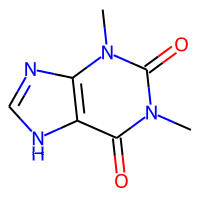
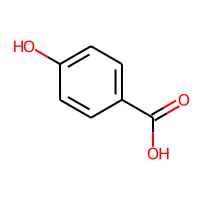
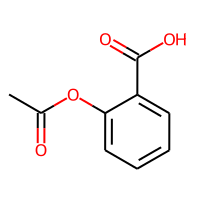
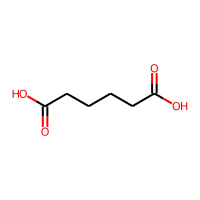
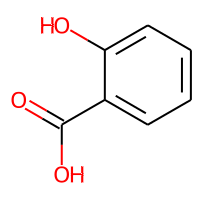
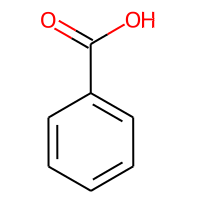
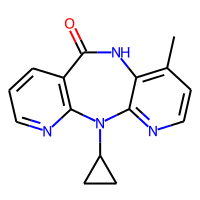

In [ ]:
# Relatório sintético dos analitos
#PandasTools.SaveXlsxFromFrame(dfr.set_index(['molecula', 'Nome', 'Metodo'])[['dd', 'dp','dh', 'Ro','dt', 'Vm','Eval','Iter']].style.format(format_semaforo), 'Sintetic_Report.xlsx', molCol='molecula')
dfr.set_index(['molecula', 'Nome', 'Metodo'])[['dd', 'dp','dh', 'Ro','dt', 'Vm','Eval','Iter']].style.format(format_semaforo).to_excel('sintetic_Report.xlsx')  # doctest: +SKIP #.groupby('molecula').groups(['Metodo', 'Nome', 'dd', 'dp','dh', 'Ro','dt', 'Vm','Eval','Iter'])
dfr.set_index(['molecula', 'Nome', 'Metodo'])[['dd', 'dp','dh', 'Ro','dt', 'Vm','Eval','Iter']].style.format(format_semaforo)#.groupby('molecula').groups(['Metodo', 'Nome', 'dd', 'dp','dh', 'Ro','dt', 'Vm','Eval','Iter'])



Nos dataframes com os ensaios experimentais por alvo, adicionou-se novos dados, como o parâmetro "Chi" (X12). Foi montado um template para exibição em html do conjunto de dados brutos para cada ensaio. 


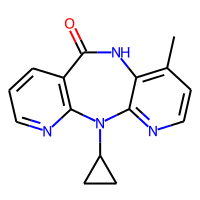

In [ ]:
#@title
# Pra enfeitar a tabela, publica-se o html;
# Pode ser via Jinja2 / templates ou diretamente através da biblioteça Pandas, como abaixo:

#dfr[['molecula', 'Nome','Metodo', 'dd', 'dp', 'dh', 'Ro', 'dt']]
#dfr.to_html(buf=None, columns=['molecula', 'Nome','Metodo', 'dd', 'dp', 'dh', 'Ro', 'dt'],
#                  col_space=None, header=True, index=True, na_rep='NaN',
#                  formatters=None, float_format=None, sparsify=None,
#                  index_names=True, justify=None,
#                  max_rows=None, max_cols=None, show_dimensions=False,
#                  decimal='.', bold_rows=True, classes=None, escape=True,
#                  notebook=False, border=None, table_id=None, render_links=False, encoding=None)

# Para o Jinja 2, usa-se:
from datetime import datetime
from IPython.display import HTML
from jinja2 import Template

# Prepara os dados:
# De origem externa:
semaforo = 'semaforo_NEV'
apelido = semaforo.split('_')[1]
dft = dfu[dfu['Metodo'].isin(metodos) & (dfu.dd.isna() == False)].copy() #dfu_semaforo_NEV
dft.reset_index(drop=True, inplace=True)

# Inclui o desenho da molécula no dataset
Chem.PandasTools.AddMoleculeColumnToFrame(dft, smilesCol='Smile', molCol='molecula', includeFingerprints=True)
Chem.PandasTools.ChangeMoleculeRendering(dft, renderer="SVG")
Chem.PandasTools.RenderImagesInAllDataFrames(images=True)
Chem.Draw.MolsToGridImage(dft['molecula'],maxMols=999999)

alvo_template = dft[(dft['classe'].isin(['cof', 'IFA'])) & (dft['Apelido']==apelido) & (dft['Metodo'].empty == False)]
alvo_template.reset_index(drop=True, inplace=True)


# Define o template
template_str = '''
<!DOCTYPE html>

<html lang="en">

<head>

    {% block head %}
    <link rel="stylesheet" href="style.css" />
    <title>{% block title %}{% endblock %} - My Webpage </title>
    {% endblock %}
</head>

<body>

    <div id="content">{% block content %}{% endblock %}</div>
    <table class="example collapse">
  <thead>
    <tr>
    <h1>Molécula Alvo experimentada na seguinte lista de solventes:</h1>
    <td>{{alvo_template}}</td>
    </tr>
    <tr>
    <td>{{alvo_stats}}</td>
    </tr>
    <tr>
    <td>{{tab_outliers}}</td>
    </tr>
    <tr>
    <td>{{tab_solv}}</td>
    </tr>
<!--
    <tr>
      {% for m in groups_metodos %}
      <th>{{ m }}</th>
      {% endfor %}
    </tr>
    <tr>
      {% for c in columns %}
      <th>{{ c }}</th>
      {% endfor %}
    </tr>
  </thead>
  <tbody>
     {% for row in rows %}
     <tr>
     {% for k, v in row.items() %}
     {% if v == 'a' %}
     <td><div class="red-circle">{{ row.letter }}</div></td>
     {% else %}
     <td><div>{{ v }}</div></td>
     {% endif %}
     {% endfor %}
     </tr>
     {% endfor %}
   </tr>
  </tbody>
-->
</table>

    <div id="footer">
        {% block footer %}
        &copy; Copyright 2021 by <a href="http://domain.invalid/">Trawtmam </a>.
        {% endblock %}
    </div>
</body>

</html>

'''
# Define o template
template = Template(template_str)

#html = template.render(
#    rows=dfr.set_index(['molecula', 'Nome', 'Metodo'])[['dd', 'dp','dh', 'Ro','dt', 'Vm','Eval','Iter']].to_dict(orient='records'),
#    columns=dfr[['dd', 'dp','dh', 'Ro','dt', 'Vm','Eval','Iter']].columns.to_list()
#)
html = template.render(
    #alvo_nome=alvo_template[['Nome']].head(1).to_html(),
    #alvo_mol=dfr[(dfr['classe']=='IFA')][['molecula']].to_dict(orient='records'),
    alvo_template = alvo_template.set_index(['molecula', 'Nome', 'Metodo'])[['dd', 'dp','dh', 'Ro','dt', 'Vm','Eval','Iter']].to_html(),#to_dict(orient='records'),
    alvo_stats = alvo_template.set_index(['molecula', 'Nome', 'Metodo'])[['dd', 'dp','dh', 'Ro','dt', 'Vm','Eval','Iter']].agg([min, max]).to_html(),#.to_dict(orient='records'),
    alvo_stats2 = alvo_template.set_index(['molecula', 'Nome', 'Metodo'])[['dd', 'dp','dh', 'Ro','dt', 'Vm','Eval','Iter']].std(),

    tab_solv = dft[(dft['classe'].isin(['solv']))][['Nome', 'Metodo', 'dd', 'dp','dh', 'Ro','dt', 'Vm', semaforo,
                                             'Ra_nelder-mead', 'RED_nelder-mead', 'X12_nelder-mead',# 'out_ruimDentro_nelder-mead', 'out_bomFora_nelder-mead',
                                             'Ra_COBYLA', 'RED_COBYLA', 'X12_COBYLA',# 'out_ruimDentro_COBYLA', 'out_bomFora_COBYLA',
                                             'Ra_SLSQP', 'RED_SLSQP', 'X12_SLSQP',# 'out_ruimDentro_SLSQP', 'out_bomFora_SLSQP',
                                             'Ra_BFGS', 'RED_BFGS', 'X12_BFGS',# 'out_ruimDentro_BFGS', 'out_bomFora_BFGS',
                                             'Ra_Mathieu', 'RED_Mathieu', 'X12_Mathieu', #'out_ruimDentro_Mathieu', 'out_bomFora_Mathieu',
                                             'Ra_Abbott', 'RED_Abbott', 'X12_Abbott',# 'out_ruimDentro_Abbott', 'out_bomFora_Abbott'
                                             ]].to_html(),

    tab_solv_stats = dft[(dft['classe'].isin(['solv']))][['Metodo', 'out_ruimDentro_nelder-mead', 'out_bomFora_nelder-mead',
                                             'out_ruimDentro_COBYLA', 'out_bomFora_COBYLA',
                                             'out_ruimDentro_SLSQP', 'out_bomFora_SLSQP',
                                             'out_ruimDentro_BFGS', 'out_bomFora_BFGS',
                                             'out_ruimDentro_Mathieu', 'out_bomFora_Mathieu',
                                             'out_ruimDentro_Abbott', 'out_bomFora_Abbott'
                                             ]].groupby('Metodo').sum().plot(kind='scatter').to_html(),

    tab_outliers = dft[(dft['classe'].isin(['solv']))].pivot_table(index='Metodo',
                                          values=[semaforo,
                                             'out_ruimDentro_nelder-mead', 'out_bomFora_nelder-mead',
                                             'out_ruimDentro_COBYLA', 'out_bomFora_COBYLA',
                                             'out_ruimDentro_SLSQP', 'out_bomFora_SLSQP',
                                             'out_ruimDentro_BFGS', 'out_bomFora_BFGS',
                                             'out_ruimDentro_Mathieu', 'out_bomFora_Mathieu',
                                             'out_ruimDentro_Abbott', 'out_bomFora_Abbott'], aggfunc=np.sum).to_html(),

    grid_mol = [], # Chem.PandasTools.FrameToGridImage(dft[(dft['classe']=='solv')], column='molecula', legendsCol='Nome'), #, legendsCol=dft[(dft['classe']=='solv')][['Nome', 'Metodo', 'dd', 'dp','dh', 'Ro','dt', 'Vm']]),
    #grid_outliers = ,

    rows = [],# dft[(dft['classe']=='solv')][['Ra_nelder-mead', 'RED_nelder-mead', 'out_ruimDentro_nelder-mead', 'out_bomFora_nelder-mead',
              #                               'Ra_COBYLA', 'RED_COBYLA', 'out_ruimDentro_COBYLA', 'out_bomFora_COBYLA',
              #                               'Ra_SLSQP', 'RED_SLSQP', 'out_ruimDentro_SLSQP', 'out_bomFora_SLSQP',
              #                               'Ra_BFGS', 'RED_BFGS', 'out_ruimDentro_BFGS', 'out_bomFora_BFGS',
                                             #'Ra_Mathieu', 'RED_Mathieu', 'out_ruimDentro_Mathieu', 'out_bomFora_Mathieu',
                                             #'Ra_Abbott', 'RED_Abbott', 'out_ruimDentro_Abbott', 'out_bomFora_Abbott'
              #                           ]].to_dict(orient='records'),
    groups_metodos = ['nelder-mead', 'COBYLA', 'SLSQP', 'BFGS', 'Mathieu', 'Abbott'],
    columns = [],# ['Ra_', 'RED_', 'out_ruimDentro_', 'out_bomFora_']
)

HTML(html)
#HTML(dfr.set_index(['molecula', 'Nome', 'Metodo'])[['dd', 'dp','dh', 'Ro','dt', 'Vm','Eval','Iter']].to_html(classes="collapse"))
# Para exportar pdf's e html's:
#HTML(string=html_out).write_pdf("report.pdf")
#HTML(string=html_out).write_pdf(args.outfile.name, stylesheets=["style.css"])
# ou no DF: .to_excel('sintetic_Report.xlsx')

In [ ]:
dft[(dft['classe']=='solv')].to_excel('semaforo_nev.xls') # Guarda uma cópia do dataframe em formato excel

In [ ]:
metodos # Só pra lembrar dos métodos...

['nelder-mead', 'COBYLA', 'SLSQP', 'BFGS', 'Mathieu', 'Abbott']

In [ ]:
tab_solv = dft[(dft['classe'].isin(['solv']))][['Nome', 'Metodo', 'dd', 'dp','dh', 'Ro','dt', 'Vm', semaforo,
                                             'Ra_nelder-mead', 'RED_nelder-mead', 'X12_nelder-mead',# 'out_ruimDentro_nelder-mead', 'out_bomFora_nelder-mead',
                                             'Ra_COBYLA', 'RED_COBYLA', 'X12_COBYLA',# 'out_ruimDentro_COBYLA', 'out_bomFora_COBYLA',
                                             'Ra_SLSQP', 'RED_SLSQP', 'X12_SLSQP',# 'out_ruimDentro_SLSQP', 'out_bomFora_SLSQP',
                                             'Ra_BFGS', 'RED_BFGS', 'X12_BFGS',# 'out_ruimDentro_BFGS', 'out_bomFora_BFGS',
                                             'Ra_Mathieu', 'RED_Mathieu', 'X12_Mathieu', #'out_ruimDentro_Mathieu', 'out_bomFora_Mathieu',
                                             'Ra_Abbott', 'RED_Abbott', 'X12_Abbott',# 'out_ruimDentro_Abbott', 'out_bomFora_Abbott'
                                             ]]


# Plota o gráfico X12
fig = px.scatter(
        tab_solv,
        color='Metodo', hover_data=tab_solv, hover_name='Nome', 
        color_discrete_sequence=px.colors.qualitative.Alphabet,
        title='Chi x RED para cada método de obtenção dos parâmetros de Hansen',
        #color_discrete_map = semaforo_color, 
        #text='Nome',
        )
for i in metodos:
  RED = 'RED_'+i
  X12 = 'X12_'+i
  fig.add_trace(go.Scatter( 
            x=tab_solv[RED],
            y=tab_solv[X12],
            #legendgroup=tab_solv['Metodo'],
            #legendgrouptitle='',
            name = i,
            #opacity=0.7,
            mode= 'markers',#'markers+text', #mode="text",
            #marker_symbol = symbols,
            marker=dict(size=6,
                        line=dict(width=1,
                        color='black',#'DarkSlateGrey'
                        )),
            textfont=dict(
                color="black",
                size=12,
                family="Times New Roman",),
            )
  )

fig.show()

Considerando a importância do volume molar no método de Hansen, é importante comparar os volumes molares obtidos através dos vários métodos de cálculo e encontrados nas bases de dados. Prepara também e compara as variações percentuais dos parâmetros calculados com os encontrados na bibliografia e correlações entre os semaforos e os parâmetros.

Pode-se calcular os parâmetros de Hansen de uma substância qualquer à partir de informações do seu comportamento em relação a substâncias cujos parâmetros são conhecidos. Assim, partindo de um ensaio de solubilidade simples, que indique a solubilidade ou não da molécula de interesse em um conjunto de solventes de parâmetros conhecidos, aplica-se metodos de otimização para determinar os parâmetros de Hansen desse soluto.

Definimos uma molécula alvo, que será o soluto nos testes. Para analisar em relação ao dataset, calculamos as propriedades desta molécula utilizando os mesmos métodos utilizados na construção do dataset para que as comparações sejam possíveis e diretas. Há mais de um método de determinação do parâmetro de Hansen utilizado na formação do dataset e disponível para uso, cabe ao pesquisador escolher a que melhor descreva o comportamento das substâncias que utiliza.


Aplica correções termodinâmicas propostas por Louwerse. Essas correções melhoram as previsões para moléculas pequenas, como as de fármacos, dado que a influência termodinâmica em suas interações são muito maiores do que com os polímeros.

In [ ]:
# Calcula a variação da entropia de mistura com base nas proporções molares,
# de acordo com a teoria das soluções regulares, para um solvente ideal.
# dSm = -R[xlnx + (1-x)ln(1-x)]

#def dS_mix(solvente, mol_alvo, T=20.0, concentra=0.5):
#    R = 8.3144621	# Cte dos gases, SI, J · K−1 · mol−1
#    T= T + 273.15 # Converte a temperatura de Celsius para Kelvin

#    RED = ((4.0*(hspD_soluto - hspD_solvente)**2.0+(hspP_soluto - hspP_solvente)**2.0+(hspH_soluto - hspH_solvente)**2.0)**0.5)
#    
#    dS_m = -R*(concentra*log(concentra)+(1.0-concentra)*log(1.0-concentra))

#    return dS_mix

# Calcula a entalpia de mistura de acordo com a teoria das soluções regulares.



# Introduz o conceito de "radii", inversamente proporcional 
# a soma dos volumes molares (Vm) dos solventes e do soluto.
# r_eff = 1/[(1/r_soluto) + (1/r_solvente)]

#def r_eff():
#  return r_eff

# Aplica as correções referentes às concentrações. O raio da esfera de Hansen é 
# definido pela razão entre a entropia e a entalpia de mistura:
# raio = dSmix/dHmix
# dHmix = -abx(1-x)
#
# onde b é o parâmetro de interação diretamente obtido da distância entre as substâncias
# b = -(1/2)*[(hspD_soluto - hspD_solvente)**2 + (hspP_soluto - hspP_solvente)**2 + (hspH_soluto - hspH_solvente)**2]

# a é o coeficiente de atividade causado pela mistura não ideal (1 para mistura ideal)
# Tomando uma concentração x=0,5 como referência, pode-se relacionar o raio da esfera de
# Hansen às variações de entalpia e entropia de mistura a qualquer concentração:
# r_eff(x) = {[dSm(x)/dHm(x)]/[dSm(0.5)/dHm(0.5)]}*r_eff(0.5) ou,
# r_eff(x=0.5) = {[[xlnx+(1-x)ln(1-x)]/x(1-x)]/4ln(0.5)}

# Considerando que as ligações de hidrogênio se formam entre aceptores e doadores,
# sendo ambos necessários para formar as ligações e que esta questão não é resolvida no
# modelo de Hansen, algumas abordagens corretivas foram propostas e já estão disponíveis
# em programas comerciais de determinação dos parâmetros de Hansen, como o HSPiP. Louwerse
# propõe a participação combinada entre as parcelas doadoras e aceptoras de hidrogênio
# as energias de dispersão e das ligações de hidrogênio:
# E_coesãoH = dHd*dHa
# A parcela de interação (ou do parâmetro de interação?) bh pode ser calculada por:

# bh = 1/2(dhd_soluto*dha_solvente + dhd_solvente*dha_soluto - dhd_soluto*dha_soluto - dhd_solvente*dha_solvente)

# Cuidado para não confundir!
# Louwerse e seu grupo obtiveram as contribuições de dhd e dha para cada solvente à partir
# das contribuições dos grupos funcionais na molécula, ajustados para coincidir com valores de
# hspH conhecidos para as substâncias. Isso está relacionado aos ácidos e bases de Lewis

# Também são incluídas as entalpias e entropias de fusão quando os solutos estão em estado
# sólido, dado que a substância somente é dissolvida após a superação da barreira de energia 
# necessária para a destruição de sua estrutura cristalina.

In [ ]:
'''
from rdkit import RDConfig
print(RDConfig.RDDataDir)
from rdkit.Chem import FragmentCatalog
from rdkit.Chem import Descriptors, Draw, Fragments, BRICS
groupFileName = os.path.join(RDConfig.RDDataDir, "FunctionalGroups.txt")

fparams = FragmentCatalog.FragCatParams(1,6,groupFileName)

print('numero de grupos funcionais a testar: ', fparams.GetNumFuncGroups())
fcat=FragmentCatalog.FragCatalog(fparams)
fcgen=FragmentCatalog.FragCatGenerator()
#fcgen.AddFragsFromMol(mol_alvo,fcat)
#fcat.GetEntryDescription()
print (Fragments.fr_NH1(m))

# lista a tabela de doadores e aceptores de hidrogênio e suas respectivas pontuações, segundo Law,....
# H donors:
# "H-bond donors", α
'alkane',0.4 
Fragments.fr_NH1
'alkyl ketone',1.5
'carbamate',2.8
'alkene',0.7 
'amine',1.5
'sulfonamide',2.8
'alkyl ether',0.9
'aldehyde',1.6
'amide',2.9
'benzene',1.0
'furan',1.7 
'urea',3.0
'alkyl thioether',1.0 
'thiol',1.7 
'pyrrole',3.0
'alkyl iodide',1.2 
'acetonitrile',1.7 
'sulfinamide',3.2
'alkyl fluoride',1.2 
'thiophenol',1.8 
'thioamide',3.3
'alkyl chloride',1.3 
'nitromethane',1.8 
'carboxylic acid',3.6
'alkyl bromide',1.3 
'dichloromethane',1.9 
'imidazole',3.7
'aryl chloride',1.3 
'alkyne',1.9
'2,2,2-trifluoroethanol',3.7
'carbon tetrachloride',1.4
'1,1,2,2-tetrachloroethane',2.0 
'phenol',3.8
'aryl ether',1.4 
'ammonia',2.0 
'trifluoroacetic acid',3.9
'aryl fluoride',1.4 
'aniline',2.1
'phosphoric acid',4.0
'pyridine',1.4 
'chloroform',2.2 
'hexafluoropropan-2-ol',4.5
'1,1,1-trichloroethane',1.5 
'alcohol',2.7
'perfluoro-tert-butanol',4.9
'alkyl ester',1.5 
'water',2.8

# H-bond acceptors β
'alkane', 0.3
'alkyne', 2.7 
'alcohol', 5.8
'carbon tetrachloride', 0.6 
'isothiocyanate', 2.7 
'imine', 5.8
'perfluoroalkane', 0.7 
'thiol', 2.7 
'ketone', 5.8
'chloroform', 0.8 
'hexafluoropropan-2-ol', 3.1 
'sulfonamide', 5.8
'dichloromethane', 1.1
'alkyl selenide', 3.4
'thioamide', 5.8
'alkene', 1.1
'thioether', 3.6
'ammonia', 6.1
'1,1,2,2-tetrachloroethane', 1.3
'nitroalkane', 3.7
'sulfone', 6.3
'1,1,1-trichloroethane', 1.4
'aryl ether', 3.7
'pyridine', 7.0
'aryl chloride', 1.6
'disulfide', 3.7
'carbamate', 7.3
'aryl bromide', 1.6
'trifluoracetic acid', 3.8
'amine', 7.8
'aryl iodide', 1.6
'pyrrole', 4.1
'sulfinamide', 8.3
'aryl fluoride', 1.6
'2,2,2-trifluoroethanol', 4.2
'amide', 8.3
'alkyl chloride', 2.2
'water', 4.5
'urea', 8.3
'alkyl bromide', 2.2
'aldehyde', 4.7
'phosphinate diester', 8.9
'alkyl iodide', 2.2
'nitrile', 4.7
'phosphonate diester', 8.9
'benzene', 2.2
'sulfate diester', 4.7
'sulfoxide', 8.9
'furan', 2.2
'thiocyanate', 4.7
'amidine', 8.9
'thiophenol', 2.2
'carboxylic acid', 5.3
'phosphoric acid', 9.3
'perfluoro-tert-butanol', 2.3
'alkyl ether', 5.3
'phosphine oxide', 9.9
'phenol', 2.7
'aniline', 5.3
'alkyl fluoride', 2.7
'ester', 5.3
'''